# **MINERIA DE TEXTOS Y PROCESAMIENTO DE LENGUAJE NATURAL**

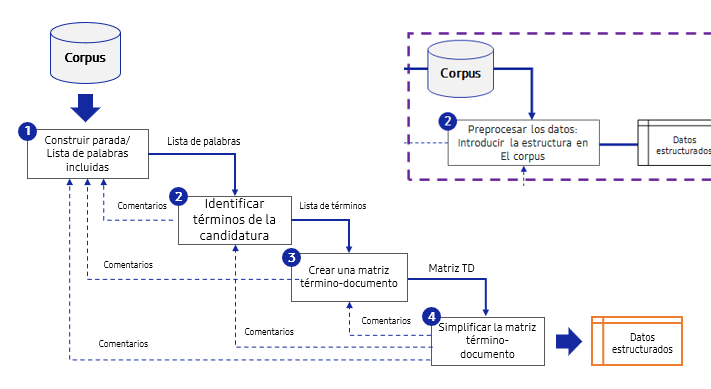

## **PROCEDIMIENTO BASICO PARA LA MINERIA DE TEXTOS**

## **1 — Construir parada / lista de palabras incluidas**

### **Qué es**

**Dos listas que configuras antes de identificar términos:**

- Stoplist (lista de parada): palabras que **NO** aportan información útil (ej. artículos, preposiciones, palabras muy frecuentes): “el”, “la”, “de”, “y”.

- Whitelist (lista incluida): palabras que quieres forzar a mantener (ej. siglas, nombres de dominio, términos de negocio).

### **Operaciones prácticas**

- Generar lista inicial con heurística (palabras más frecuentes) y luego limpiarla manualmente.

- Considerar idioma y domain-specific stopwords (ej. “paciente” puede ser irrelevante en un corpus médico si aparece siempre).

- Aplicar antes del cálculo de frecuencias o al filtrar candidatos.

- Salida: lista de palabras a ignorar / a preservar.

---

####**EJEMPLO**

In [ ]:
!pip install spacy -q
!python -m spacy download es_core_news_sm -q

import re
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

# Documentos -
docs = [
    "La inteligencia artificial está transformando la industria tecnológica.",
    "La industria utiliza modelos de inteligencia artificial para automatizar procesos.",
    "Los modelos avanzados de IA permiten nuevas aplicaciones tecnológicas."
]

# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

stoplist = {"la", "el", "los", "de", "y", "para", "una", "un", "en", "esta", "está"}
whitelist = {"ia", "inteligencia artificial"}

def limpiar(text):
    text = text.lower()
    text = re.sub(r"[^a-záéíóúñ ]", " ", text)
    return text

def extraer_candidatos(texto):
    texto = limpiar(texto)
    doc = nlp(texto)

    candidatos = []

    for token in doc:
        if token.lemma_ not in stoplist:
            if token.pos_ in {"NOUN", "PROPN"} or token.lemma_ in whitelist:
                candidatos.append(token.lemma_)

    return candidatos

# Extraer candidatos de cada documento
lista_candidatos = [extraer_candidatos(t) for t in docs]
print("Candidatos extraídos:")
print(lista_candidatos)
print()

# Crear documentos filtrados
docs_filtrados = [" ".join(cands) for cands in lista_candidatos]

# Aplicar TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=1)
matriz_tfidf = vectorizer.fit_transform(docs_filtrados)

# Mostrar resultados
terminos = vectorizer.get_feature_names_out()
print("Términos extraídos:")
print(terminos)
print()
print("Matriz TF-IDF:")
print(matriz_tfidf.toarray())

# Opcional: Mostrar términos más importantes por documento
import numpy as np
print("\nTérminos más relevantes por documento:")
for i, doc in enumerate(docs):
    print(f"\nDocumento {i+1}: '{doc[:50]}...'")
    scores = matriz_tfidf[i].toarray()[0]
    top_indices = np.argsort(scores)[-5:][::-1]
    for idx in top_indices:
        if scores[idx] > 0:
            print(f"  - {terminos[idx]}: {scores[idx]:.3f}")

In [ ]:
import spacy

nlp = spacy.blank("es")
doc = nlp("Hola, esto es una prueba de tokenización.")

for token in doc:
    print(token.text)




---



## **2 — Identificar términos de la candidatura (candidates)**

- **Objetivo:** Proponer todos los posibles términos/expresiones que podrían ser relevantes.

### **Subprocesos comunes**

- **Tokenización** — separación en tokens (palabras).

- **Normalización** — minúsculas, quitar puntuación, normalizar acentos.

- **Stemming/Lematización** — reducir variaciones morfológicas (p. ej. “correr”, “corriendo” → lema “correr”).

- **Extracción de n-gramas** — además de unigramas, extraer bigramas/ trigrams con frecuencia mínima.

- **POS-tagging + reglas** — mantener solo sustantivos, sustantivo+adjetivo, nombres propios, etc.

- **Expresiones regulares** — detectar códigos, fechas, porcentajes, URLs.

- **Filtrado por stoplist/whitelist** — aplicar las listas del paso 1.

### **Ejemplo de criterio**

- Mantener n-gramas con frecuencia ≥ 5 y que no estén en stoplist.

- Mantener tokens con POS=NOUN o PROPN.

- **Salida:** Lista de términos candidatos (términos / frases que pasarán a la matriz).

---

.

## **3 — Crear una matriz término-documento (matriz TD)**

### **Qué es**

Matriz con filas = términos candidatos y columnas = documentos (o viceversa). Cada celda representa la importancia del término en ese documento.

### **Representaciones habituales**

* **TF (Term Frequency):** conteo simple del término en el documento.

* **TF normalizada (p. ej. frecuencia relativa):** TF(t,d) / longitud(d).

**IDF (Inverse Document Frequency):**

IDF(t) = log(N / (1 + n_t))

* donde N = número total de documentos;

* n_t = número de documentos que contienen t.

**TF–IDF:**

TF-IDF(t,d) = TF(t,d) × IDF(t)

(es la representación más común para ponderar importancia global vs local).

### **Otras opciones**

* BM25 para ranking más sofisticado.

* Binary presence/absence si sólo interesa si aparece o no.

* **Embeddings:** en lugar de matriz TD clásica, representar términos o documentos como vectores densos (word2vec, fastText, BERT).

**Salida:** Matriz TD (sparse) lista para análisis.

---

.

## **4 — Simplificar la matriz término-documento (reducción / selección)**

**Objetivo:** Reducir ruido y dimensiones para producir datos estructurados útiles.

### **Técnicas de simplificación**

**Filtrado por frecuencia:**

Eliminar términos muy raros (TF total < 2) y muy frecuentes (presencia en > 90% documentos).

**Scoring y selección de términos:**

* Ordenar por TF-IDF promedio, Chi-cuadrado (con etiquetas), Mutual Information, o C-Value (para multi-palabras).

* Seleccionar top-k (ej. top 500) o aquellos por umbral.

**Agrupación / Normalización:**

* Unir sinónimos (thesaurus) o aplicar clustering semántico de términos (k-means sobre embeddings).

* Expandir/contratar con reglas (p. ej. “hipertensión arterial” ≈ “HTA”).

**Reducción dimensional:**

* LSA / SVD para extraer temas latentes.

* UMAP / PCA para visualización o clustering.

**Validación manual (retroalimentación):**

* Revisar listas / etiquetas y ajustar stoplist/whitelist/reglas.

**Salida:** lista final de términos relevantes + matriz reducida, o directamente datos estructurados (p. ej. CSV con columnas “documento, término, score, frecuencia”).


---

###**MODELOS DE SPACY Y QUE ES SPACY**

spaCy es una de las bibliotecas más poderosas y modernas para Procesamiento de Lenguaje Natural (NLP) en Python. Es rápida, eficiente y está diseñada para aplicaciones reales, no solo investigación.

spaCy es una librería enfocada en ejecutar tareas de análisis de lenguaje natural de forma eficiente y profesional. Está creada para trabajar con grandes volúmenes de textos y para construir aplicaciones reales, no solo para investigación académica. Viene con modelos entrenados para distintos idiomas, incluyendo español.

**spaCy es especialmente útil en proyectos de:**

* minería de textos

* clasificación documental

* extracción de información

* sistemas de recomendación de textos

* análisis forense digital

* preparación de texto para modelos de machine learning

* resumen, análisis semántico y segmentación de documentos

.

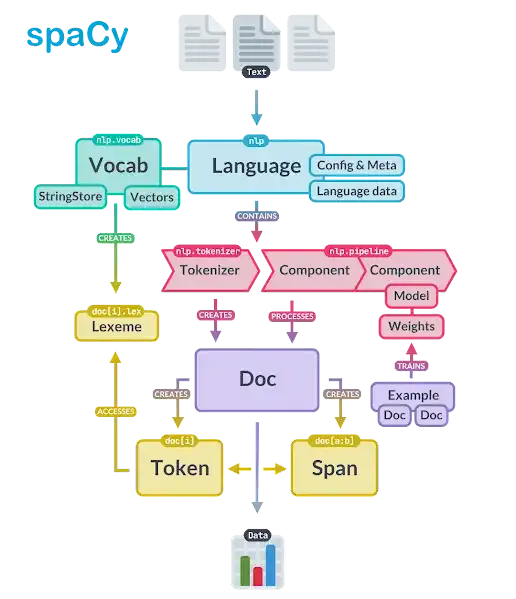


.

###**Modelos de spaCy por idioma**
**Para Español:**

####**PEQUEÑO - Rápido pero menos preciso**

> nlp = spacy.load("es_core_news_sm")  # ~13 MB

#### **MEDIANO - Balance entre velocidad y precisión**

> nlp = spacy.load("es_core_news_md")  # ~43 MB

#### **GRANDE - Más preciso pero más lento**

> nlp = spacy.load("es_core_news_lg")  # ~545 MB

####**TRANSFORMERS - Máxima precisión (usa modelos tipo BERT)**

> nlp = spacy.load("es_dep_news_trf")  # ~440 MB

**Para Inglés:**

pythonnlp = spacy.load("en_core_web_sm")   # Pequeño
nlp = spacy.load("en_core_web_md")   # Mediano
nlp = spacy.load("en_core_web_lg")   # Grande
nlp = spacy.load("en_core_web_trf")  # Transformer

####**Otros idiomas disponibles:**

* Alemán: de_core_news_sm/md/lg
* Francés: fr_core_news_sm/md/lg
* Italiano: it_core_news_sm/md/lg
* Portugués: pt_core_news_sm/md/lg
* Chino: zh_core_web_sm/md/lg
* Japonés: ja_core_news_sm/md/lg

Y más de 20 idiomas...


####**Etiquetas comunes:**

* NOUN: sustantivo
* VERB: verbo
* ADJ: adjetivo
* ADV: adverbio
* PROPN: nombre propio
* DET: determinante (el, la, un)
* ADP: preposición (de, en, para)


####**¿Cómo funciona internamente?**
Los modelos usan redes neuronales entrenadas con millones de textos:

**Entrenamiento (ya hecho por spaCy):**

* Toman textos etiquetados manualmente
* La red neuronal aprende patrones
* **Ejemplo:** "palabras que terminan en -mente suelen ser adverbios"


**Predicción (cuando tú lo usas):**

* Convierte palabras en números (vectores)
* Pasa por capas de la red neuronal
* Predice etiquetas basándose en patrones aprendidos

.


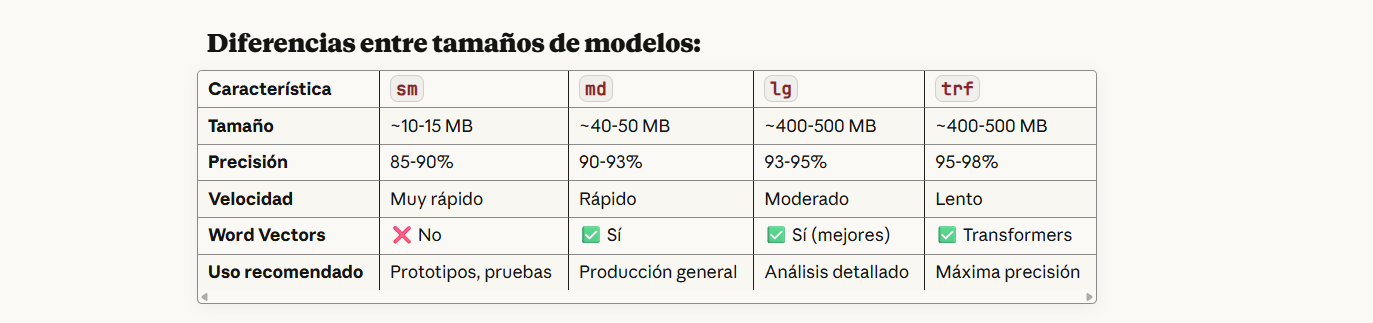

---

## **Recoleccion de Datos de Diferentes Recursos**

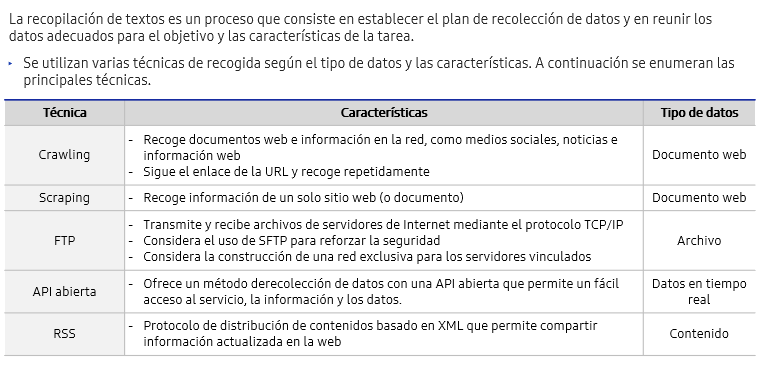

**FTP**

In [ ]:
from ftplib import FTP

ftp = FTP("ftp.dlptest.com")
ftp.login()  # servidor de prueba

archivo = "test.txt"
with open("descargado.txt", "wb") as f:
    ftp.retrbinary(f"RETR {archivo}", f.write)

ftp.quit()
print("Archivo descargado.")

**RSS**

RSS es un formato XML que distribuye contenido actualizado como noticias o blogs. Sirve para monitorear publicaciones nuevas sin revisar manualmente la web.

**Ejemplo en Python:**

In [ ]:
import feedparser

feed = feedparser.parse("https://news.un.org/feed/subscribe/en/news/all/rss.xml")

for entrada in feed.entries[:3]:
    print("Título:", entrada.title)





---

###**EJERCICIO 1 — LECTURA DE TWEETS CON LA API DE TWITTER (Tweepy)**

1. **Importamos Tweepy**

Es la librería oficial más usada para trabajar con Twitter.

2. **Introducimos las claves**

Twitter no deja usar su API sin identificarte.
Estas claves funcionan como usuario y contraseña de aplicaciones.

3. **Creas la conexión a Twitter**

auth = OAuthHandler(...) inicia la autenticación.
api = tweepy.API(auth) permite usar funciones como buscar tweets.

4. **Buscas tweets con una palabra clave**

Puedes cambiarla por lo que quieras: “economía”, “deportes”, etc.

5. **Filtras ubicación y cantidad**

Puedes obtener tweets solo de tu área.

6. **Guardas los tweets en una lista**

Luego puedes analizarlos.

In [ ]:
# Importamos la biblioteca tweepy, que permite conectarnos a Twitter
import tweepy
from tweepy import OAuthHandler

# Estas son tus credenciales de la API de Twitter.
# DEBEN sustituir el texto dentro de las comillas por tus propios valores.
my_consumer_key = "CONSUMER_KEY"
my_consumer_secret = "CONSUMER_SECRET"
my_access_token = "ACCESS_TOKEN"
my_access_secret = "ACCESS_SECRET"

# Inicializamos el proceso de autenticación con las claves principal y secreta
auth = OAuthHandler(my_consumer_key, my_consumer_secret)

# Añadimos el token de acceso (nos da permiso para usar una cuenta)
auth.set_access_token(my_access_token, my_access_secret)

# Creamos un objeto API para poder llamar a Twitter
# timeout = 10 (si tarda más de 10 segundos, detiene la petición)

api = tweepy.API(auth, timeout=10)

# Definimos una palabra clave que queremos buscar
my_keyword = "inteligencia artificial"

# Ubicación en formato "latitud,longitud,radio"
# Puedes cambiarlo por tu ciudad
my_location = "40.4168,-3.7038,50km"   # Ejemplo: Madrid + 50km

# Número de tweets a obtener
n_tweets = 20

# Creamos una lista para almacenar los tweets descargados
my_tweets = []

# Usamos Cursor para buscar tweets:
# q = palabra clave y excluir retweets
# lang = "es" para español (o "en" para inglés)
# result_type = "recent" quiere decir tweets recientes

for status in tweepy.Cursor(api.search_tweets,
                            q=my_keyword + " -filter:retweets",
                            lang="es",
                            result_type="recent",
                            geocode=my_location).items(n_tweets):

    # Guardamos solo el texto del tweet
    my_tweets.append(status.text)

# Mostramos los tweets obtenidos
for t in my_tweets:
    print("—", t)


####**Y como obtenemos esa informacion faltante?**

**Paso 1 — Ir a la página**

**Buscan:**
* https://developer.twitter.com

**Paso 2 — Iniciar sesión con tu cuenta normal de Twitter**
**Paso 3 — Solicitar acceso de desarrollador**

**Twitter te pedirá:**

- para qué usarás la API (contestar algo simple como “investigación académica”)

- confirmar tu correo

- aceptar términos

**Paso 4 — Crear un Proyecto y una Aplicación**

**Twitter te pedirá:**

- nombre del proyecto

- nombre de la aplicación

**Paso 5 — Twitter te dará tus claves**

**Obtendrán:**

- API Key

- API Secret

- Access Token

- Access Token Secret

**Esas 4 se ponen en el script.**

---

### **EJERCICIO 2 - Análisis de HTML con BeautifulSoup4**

**Que haremos?**

1. **Descargar una página web**

requests.get(URL) obtiene el HTML.

2. **Analizar el HTML con BeautifulSoup**

**Este permite leer objetos como:**

- párrafos < p>

- títulos < h1>, < h2>

- enlaces < a>

3. **Extraer todos los párrafos**

soup.find_all('p') te devuelve una lista con cada párrafo.

4. **Construir un texto limpio**

Quitas saltos de línea y lo juntas todo.

In [ ]:
# Importamos la biblioteca requests (se usa para descargar páginas) y bs4 (BeautifulSoup) para poder analizar HTML
import requests, bs4

# Descargamos el contenido HTML de la página elegida
# Pueden sustituir esta URL por cualquier página que quieran analizar

res = requests.get("https://www.ibm.com/mx-es/think/topics/machine-learning")

# Creamos el objeto BeautifulSoup para leer el HTML 'html.parser', este usa el parser de Python
soup = bs4.BeautifulSoup(res.text, 'html.parser')

# Buscamos todos los párrafos de la página <p>
x = soup.find_all('p')

# Creamos una variable para almacenar el texto extraído
text = ''

# Recorremos todos los párrafos encontrados
for i in range(len(x)):
    # Añadimos cada párrafo a la variable text
    text += x[i].text.strip() + '\n'

# Imprimimos el contenido extraído
print(text)


El machine learning es una rama de la inteligencia artificial (IA) centrada en entrenar a computadoras y máquinas para imitar el modo en que aprenden los humanos, realizar tareas de forma autónoma y mejorar su rendimiento y precisión a través de la experiencia y la exposición a más datos.
UC Berkeleydesglosa el sistema de aprendizaje de un algoritmo de machine learning en tres partes:
Boletín de la industria
Obtenga insights curados sobre las noticias más importantes e intrigantes de la IA. Suscríbase a nuestro boletín semanal Think. Consulte la Declaración de privacidad de IBM .
Su suscripción se entregará en inglés. En cada boletín, encontrará un enlace para darse de baja. Puede gestionar sus suscripciones o darse de baja aquí. Consulte nuestra Declaración de privacidad de IBM para obtener más información.
Dado que el deep learning y el machine learning tienden a utilizarse indistintamente, vale la pena notar las diferencias entre ambos. El machine learning, el deep learning y redes 

# **Manipulacion de Cadenas**

- Se utiliza para hacer patrones de String.
- Útil para reconocer y procesar patrones de cadenas complejas en el preprocesamiento de datos de texto.
- Más potente que las combinaciones de las funciones o métodos de cadena habituales.
- Soportado por muchos lenguajes, incluyendo Python.

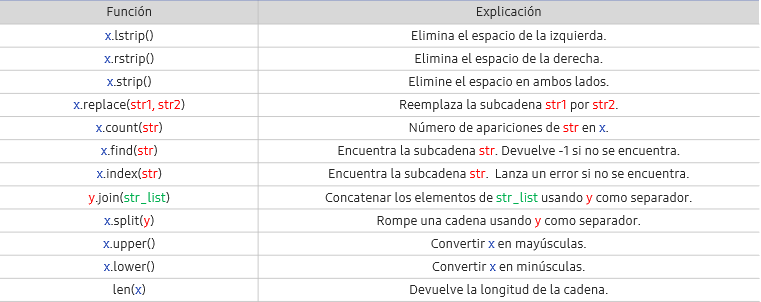

##**Metacaracteres**

## **Metacaracteres y Expresiones Regulares**

Las expresiones regulares (regex) son herramientas potentes para reconocer, buscar y manipular patrones dentro de cadenas de texto. Los metacaracteres, que son caracteres con significados especiales usados para definir estos patrones.

.

## **1. Conjuntos de caracteres [ ]**

### **Explicación**

Una expresión como [abc] coincide con a, b o c.

Se puede definir un rango usando -, como [a-z].

Para negar un conjunto se usa [^ ] como primer carácter.

### **Ejemplos**

* [abc] → coincide con a, b o c

* [0-9] → cualquier dígito

* [^A-Z] → cualquier carácter que no sea mayúscula

.

## **2. Abreviaturas de conjuntos**

### **Explicación y ejemplos**

**\w → equivale a [a-zA-Z0-9_]**  
**Ejemplo:** \w+ coincide con palabras como Hola_123

**\W → equivale a [^a-zA-Z0-9_]**  
**Ejemplo:** caracteres no alfanuméricos como !@#

**\d → equivale a [0-9]**  
**Ejemplo:** \d\d\d coincide con 123

**\D → equivale a [^0-9]**  
**Ejemplo:** cualquier letra o símbolo

**\s → espacio en blanco**  
Incluye espacio, tabulación, salto de línea.

**\S → carácter que NO sea espacio**

.

## **3. El punto .**

### **Explicación**

Coincide con cualquier carácter, excepto salto de línea.

### **Ejemplo**

* a.c → coincide con abc, a-c, a5c, etc.

.

## **4. Cuantificadores (*, +, ?, { })**

### **Explicación**

Estos indican cuántas veces debe repetirse el elemento previo.

'* → cero o más repeticiones  
Ejemplo:  
ha* coincide con: h, ha, haa, haaa…

'+ → una o más repeticiones  
Ejemplo:  
ha+ coincide con: ha, haa, haaa… pero no con h.

'? → cero o una vez  

.

**Ejemplo:**

* colou?r coincide con color y colour

* '{m} → exactamente m repeticiones  

.

**Ejemplo:**

* \d{4} coincide con 2024

* '{m,n} → entre m y n repeticiones  
Ejemplo: a{2,4} coincide con: aa, aaa, aaaa

.

## **5. Anclas: ^ y $**

**^ → inicio de la cadena**

**Ejemplo:**  
* ^Hola coincide solo si el texto empieza con Hola

**$ → final de la cadena**

**Ejemplo:**  
* fin$ coincide si el texto termina en fin

.

## **6. Alternancia: |**

**Permite usar lógica “o”.**

**Ejemplo:**  

* gato|perro coincide con gato o perro

.

## **7. Agrupación con paréntesis ( )**

**Sirve para:**  
- agrupar patrones,  
- capturar subexpresiones,  
- aplicar cuantificadores a grupos completos.

### **Ejemplos**

* (abc)+ → abc, abcabc, abcabcabc

* (\d+)\D+(\d+) → ejemplo del slide para capturar dos números separados por texto

.

---

## **Ejemplos**

### **1. Capturar dos números separados por texto**

**Expresión del slide:**

* (\d+)\D+(\d+)

**Qué hace:**

* (\d+) captura el primer número  
* \D+ captura caracteres no numéricos intermedios  
* (\d+) captura el segundo número

### **2. Detectar vocales minúsculas**

[aeiou]

### **3. Detectar letras mayúsculas excepto X**

[^X]

### **4. Coincidir cualquier caracter entre dos letras**

a.c

---

###**Ejercicio 1: Limpieza y extracción estructurada de un texto desordenado**

**Objetivo:**
A partir de un texto desordenado (como los que aparecen en logs, formularios llenados mal, o mensajes de clientes),
extraer:

- Nombre (solo letras)

- Correo electrónico

- Teléfono (distintos formatos)

- Frases que contengan números y palabras mezcladas


In [ ]:
import re

texto = """
Nombre: Juan Pérez
Correo: juan_perez95@example.com
Teléfono: +507 6123-4567
Mensaje: Mi pedido 123A llegó tarde a las 7pm, ticket 884-XX.
"""

# 1. Nombre (solo letras y espacios)  -> ^, grupos, rangos, +
patron_nombre = re.compile(r"Nombre:\s*([A-Za-zÁÉÍÓÚáéíóúñÑ ]+)")
nombre = patron_nombre.search(texto)

# 2. Correo -> \w, ., +, @, rangos
patron_correo = re.compile(r"Correo:\s*([\w\.-]+@[\w\.-]+\.\w+)")
correo = patron_correo.search(texto)

# 3. Teléfono -> \d, +, { }, ( )
patron_telefono = re.compile(r"Teléfono:\s*(\+?\d{1,3}\s?\d{3,4}[- ]?\d{4})")
telefono = patron_telefono.search(texto)

# 4. Frases con mezcla palabra+número  -> ( ), \d+, \w+, alternancia
patron_mezcla = re.compile(r"\b(\w+\d+|\d+\w+)\b")
mezclas = patron_mezcla.findall(texto)

print("Nombre:", nombre.group(1))
print("Correo:", correo.group(1))
print("Teléfono:", telefono.group(1))
print("Mezclas palabra+número:", mezclas)


Nombre: Juan Pérez
Correo: juan_perez95@example.com
Teléfono: +507 6123-4567
Mezclas palabra+número: ['juan_perez95', '507', '6123', '4567', '123A', '7pm', '884']


---

###**Ejercicio 2: Validación completa de un formulario con regex**

**Objetivo:**
Validar diferentes campos simulando un formulario:

- Usuario: solo letras o _ y de 4 a 12 caracteres

- Contraseña: al menos 1 mayúscula, 1 número y 1 símbolo

- Fecha: formato DD/MM/AAAA

- Dirección: detectar número + nombre de calle

- Extra: Encontrar palabras que NO contengan vocales (usa [^ ])

In [ ]:
import re

data = """
usuario: cleidys_gz
password: Abc12@!
fecha: 16/11/2025
direccion: 123 Avenida Central
nota: Los códigos XYZ, RT, RHMN son ejemplos.
"""

# 1. Usuario -> ^, \w, { }
re_user = re.compile(r"usuario:\s*([A-Za-z_]{4,12})")
user = re_user.search(data)

# 2. Password -> ( ), ?= lookaheads, \d, \W, +
re_pass = re.compile(
    r"password:\s*(?=.*[A-Z])(?=.*\d)(?=.*\W).+"
)
password = re_pass.search(data)

# 3. Fecha DD/MM/AAAA -> \d{2}, \d{4}
re_fecha = re.compile(r"fecha:\s*(\d{2}/\d{2}/\d{4})")
fecha = re_fecha.search(data)

# 4. Dirección: número + texto -> \d+, \w+, espacios \s+, grupos
re_direccion = re.compile(r"direccion:\s*(\d+\s+[A-Za-zÁÉÍÓÚáéíóúñÑ ]+)")
direccion = re_direccion.search(data)

# 5. Palabras sin vocales -> ^, [^aeiou], rangos, \b
re_sinvocal = re.compile(r"\b[^aeiouAEIOU\s]+\b")
sinvocales = re_sinvocal.findall(data)

print("Usuario válido:", user.group(1))
print("Password válida:", password.group(0).split(':')[1].strip())
print("Fecha:", fecha.group(1))
print("Dirección:", direccion.group(1))
print("Palabras sin vocales:", sinvocales)


Usuario válido: cleidys_gz
Password válida: Abc12@!
Fecha: 16/11/2025
Dirección: 123 Avenida Central
Palabras sin vocales: ['16/11/2025', '123', 'XYZ', 'RT', 'RHMN']


---

# **PROCESAMIENTO DE LENGUAJE NATURAL**

####**Qué es el Procesamiento del Lenguaje Natural (PLN)**

**El Procesamiento del Lenguaje Natural (PLN o NLP) es la rama de la inteligencia artificial que se encarga de permitir que las computadoras entiendan, interpreten, generen y trabajen con el lenguaje humano.**

.

> *El lenguaje natural se refiere al lenguaje que las personas utilizan de forma natural en su vida cotidiana.*

> *El Procesamiento del Lenguaje Natural (PLN) es un campo académico que permite a los ordenadores comprender y generar un lenguaje natural.*

.

**Caracteristicas/funciones :**

- Extrae características de los datos de texto para clasificarlos, resumirlos, agruparlos y realizar analisis de sentimientos.

- Interseccion de la linguistica y la IA
- Basado en modelos estadísticos
- Diferente de la forma en que los humanos entienden el lenguaje
- Requiere la transformacion en un modelo estructurado

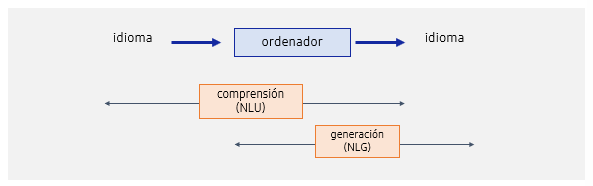

## **¿Qué compone el PLN?**

El Procesamiento del Lenguaje Natural se organiza en varias tareas que transforman texto bruto en información útil. Estas áreas pueden verse como una cadena de pasos que va desde procesar texto sin estructura hasta generar lenguaje coherente.

.

### **Tokenización**
**Proceso de dividir un texto en unidades mínimas:**
* palabras
* subpalabras
* símbolos

**Ejemplo:**

    "Los gatos duermen mucho" → ["Los", "gatos", "duermen", "mucho"]

---

### **Lematización y Stemming**
**Reducción de palabras a su forma base:**
* Lematización: devuelve una forma válida del diccionario.  
* Stemming: recorte aproximado de la raíz.

**Ejemplos:**

    "caminando", "caminará" → "caminar" (lematización)  
    "caminando" → "camin" (stemming)


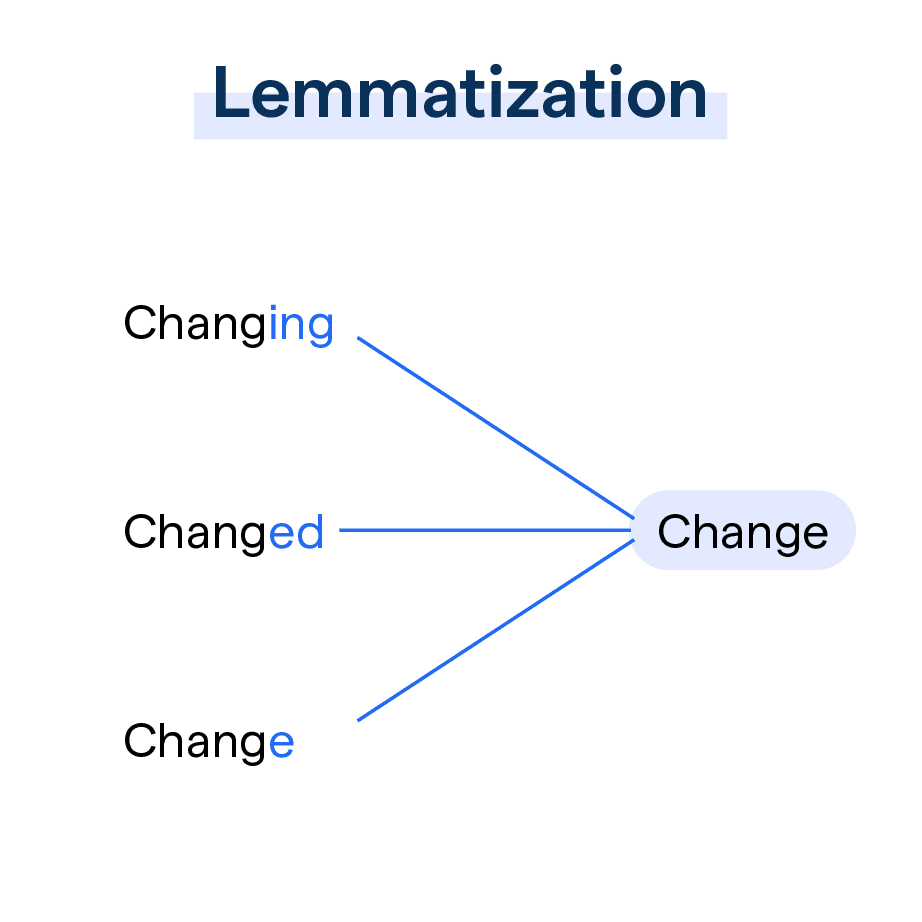

.


### **POS Tagging (etiquetado morfosintáctico)**
**Asigna la categoría gramatical a cada palabra:**

* sustantivo
* verbo
* adjetivo
* adverbio  
etc.

**Ejemplo:**  

    "Ellos corren rápido" → PRON, VERB, ADV


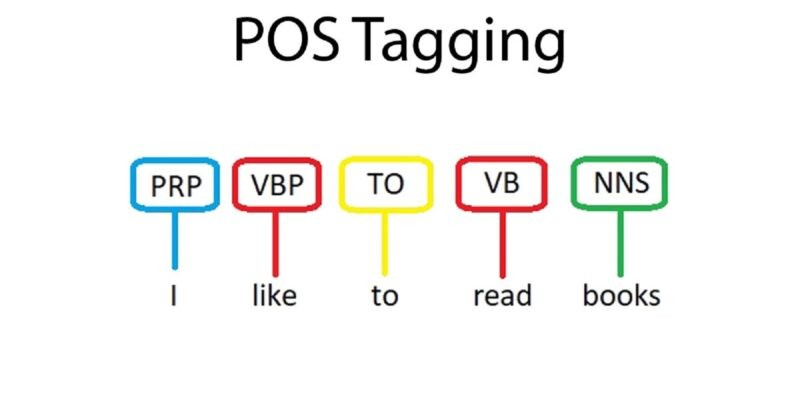


### **Parsing (análisis sintáctico)**
**Determina la estructura de la oración:**

* qué palabras dependen de cuáles
* qué roles cumplen (sujeto, objeto, modificador)

Permite construir árboles sintácticos.

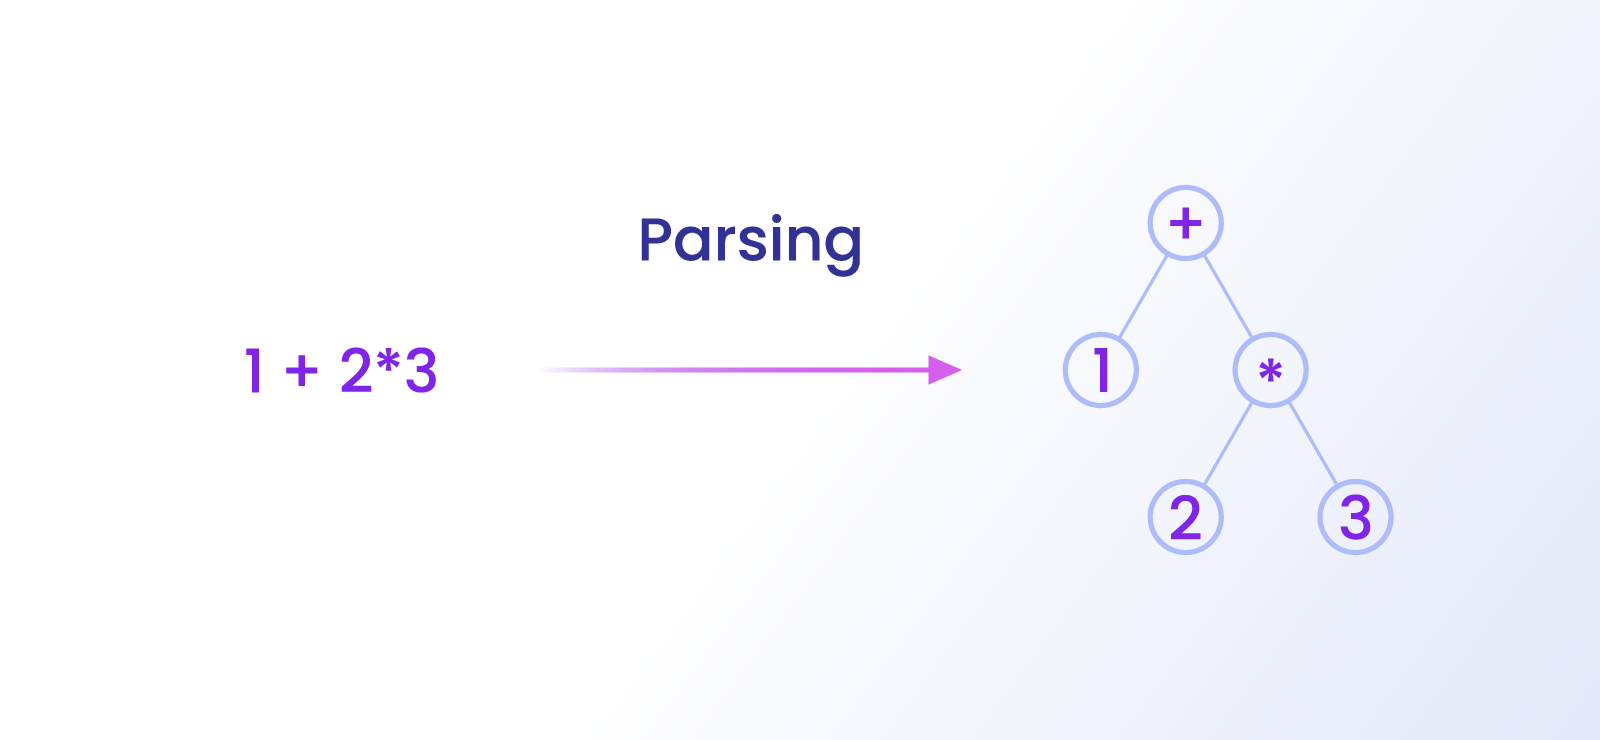

.


### **Análisis semántico**
**Intenta comprender el significado:**

* desambiguación de palabras
* extracción de entidades
* relaciones entre conceptos

### **Análisis pragmático**
**Interpreta intención y contexto:**

* qué quiere decir realmente el hablante
* inferencias
* tono y objetivo comunicativo

### **Modelamiento del lenguaje**
**Modelos capaces de:**

* predecir la siguiente palabra
* completar texto
* reconstruir frases
* calcular probabilidades de secuencias

### **Generación de Lenguaje Natural (NLG)**
**Producción automática de texto coherente:**

* redacción
* resúmenes
* descripciones
* respuestas conversacionales

.

### **Traducción automática**
Conversión de texto entre idiomas usando modelos secuenciales.

### **Clasificación de texto**
**Asignación de etiquetas a documentos:**
* spam / no spam
* sentimiento
* temas
* intención del usuario

.

## **2. ¿Por qué es necesario el PLN?**

El lenguaje está presente en casi todas las actividades humanas.  
El PLN permite que las máquinas interactúen con texto de forma funcional.

**Aplicaciones:**
* atención al cliente
* motores de búsqueda
* asistentes virtuales
* análisis de opiniones en redes sociales
* clasificación de documentos
* traducción automática
* análisis educativo
* medicina (informes clínicos)
* derecho (documentos legales)
* economía y finanzas

.
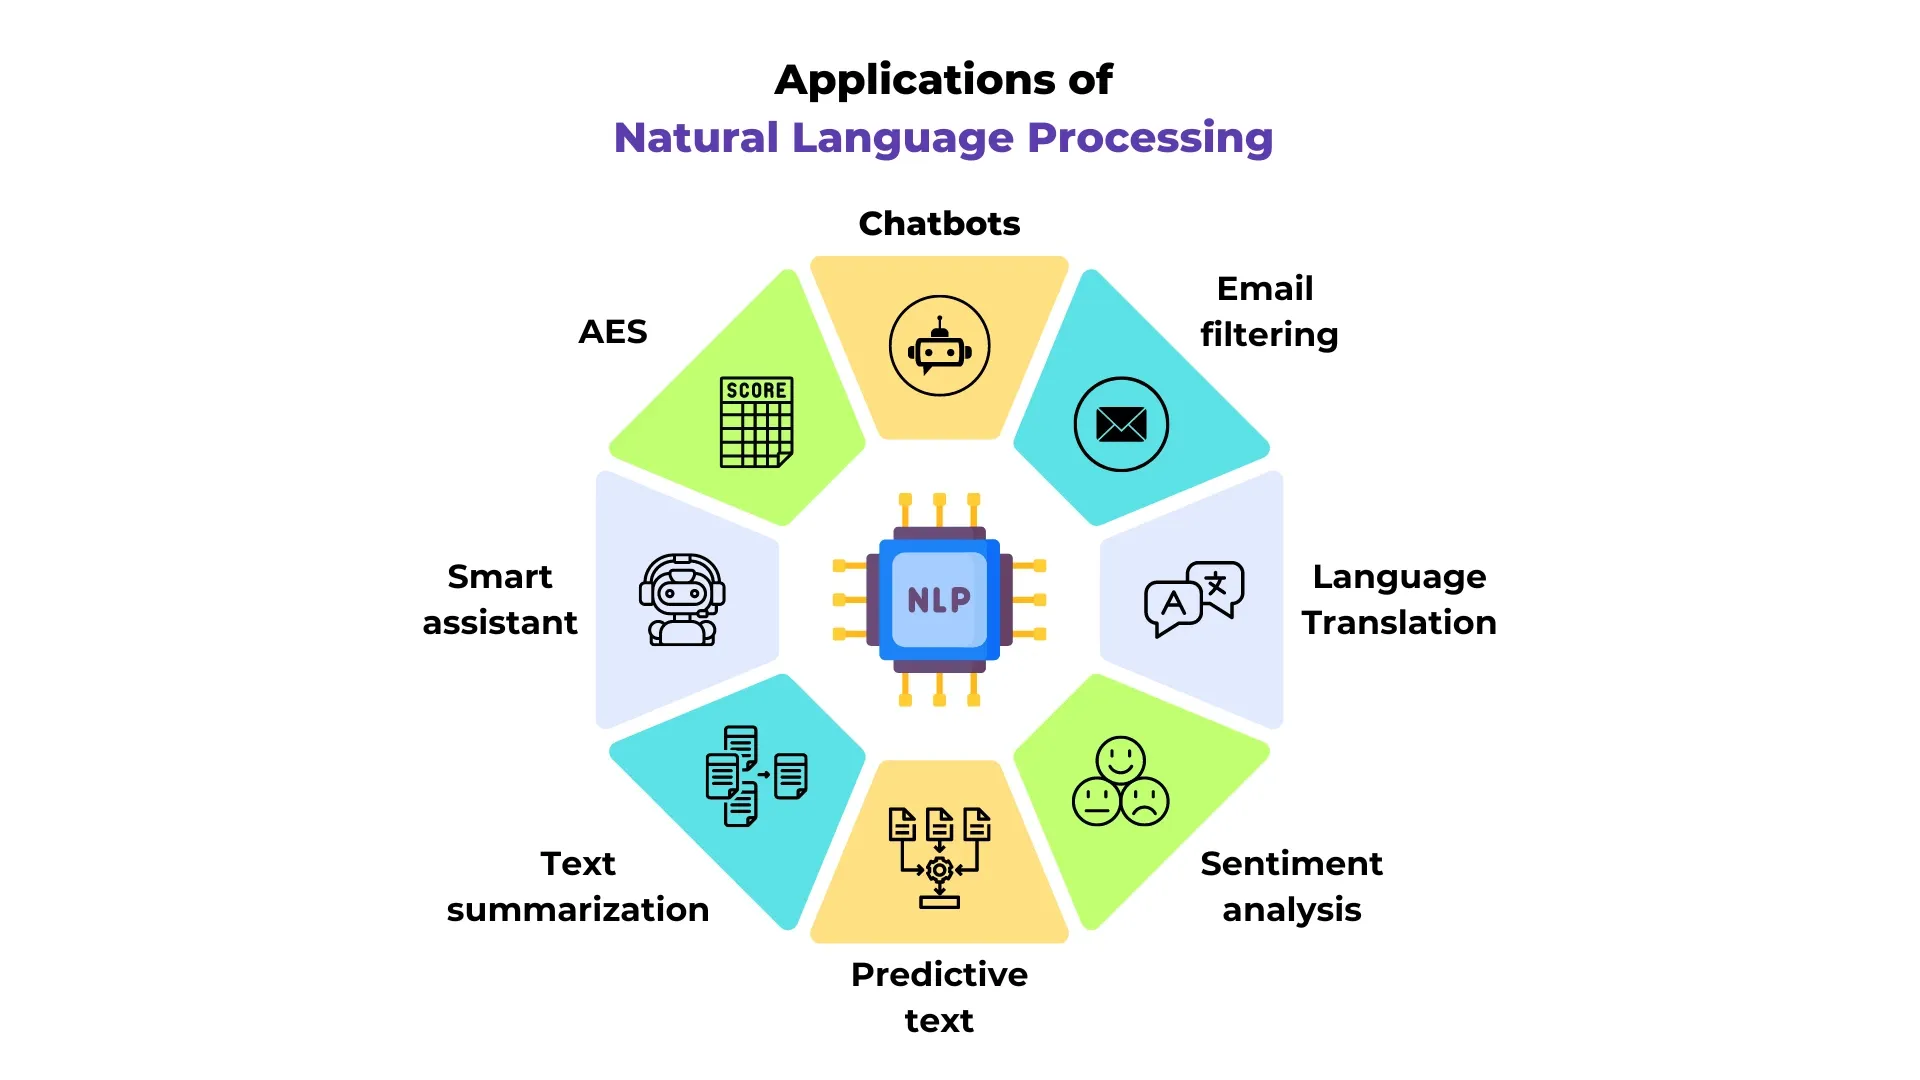

.

Sin PLN, las máquinas no podrían comprender ni producir lenguaje útil.

.

## **3. ¿Qué requiere el PLN?**

### **Datos**
Grandes corpus de texto para entrenar modelos.

### **Representaciones numéricas**
**Métodos para convertir palabras en números:**

* Bag of Words
* TF-IDF
* Word2Vec
* Embeddings contextuales (BERT, GPT)

.

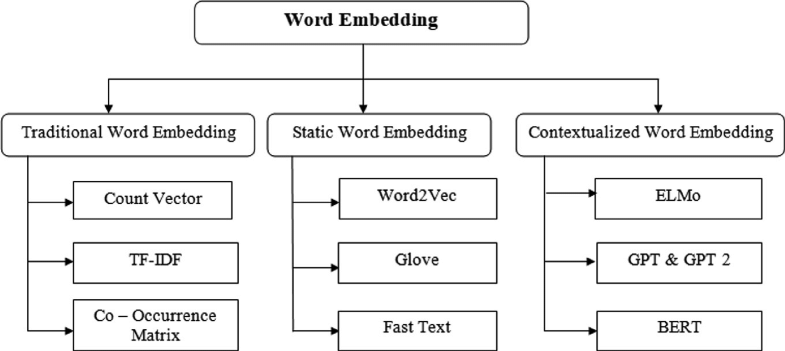

.

### **Algoritmos**
**Tres enfoques principales:**
* reglas lingüísticas
* métodos estadísticos
* redes neuronales profundas

### **Modelos entrenados**
**Modelos adaptados a la tarea específica:**

* clasificación
* traducción
* generación
* análisis sintáctico

### **Recursos computacionales**
**Necesarios para entrenar modelos modernos:**

* GPUs
* servidores de alto rendimiento
* cómputo en la nube

---

####**Flujo de trabajo del NLLP**

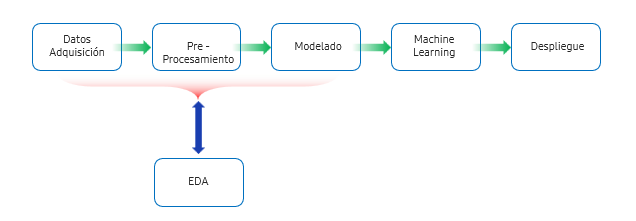

## **¿Cómo se realiza un sistema de PLN?**

### **Recolección de datos**
**Fuentes típicas:**

* tweets
* artículos
* chats
* documentos
* páginas web

### **Preprocesamiento**
* limpieza de texto
* normalización
* tokenización
* eliminación de ruido
* lematización o stemming

### **Representación numérica**
**Transformar palabras en vectores con:**
* Bag of Words
* TF-IDF
* Word2Vec
* Embeddings modernos

### **Selección del enfoque**
**Elegir el método adecuado:**

* reglas
* estadístico
* deep learning

### **Entrenamiento**
Entrenar el modelo usando ejemplos reales.

### **Evaluación**
**Métricas típicas:**
* precisión
* recall
* F1-score

### **Implementación**
**Construir la aplicación final:**

* chatbot
* detector de sentimiento
* clasificador de temas
* traductor
* generador de texto

.

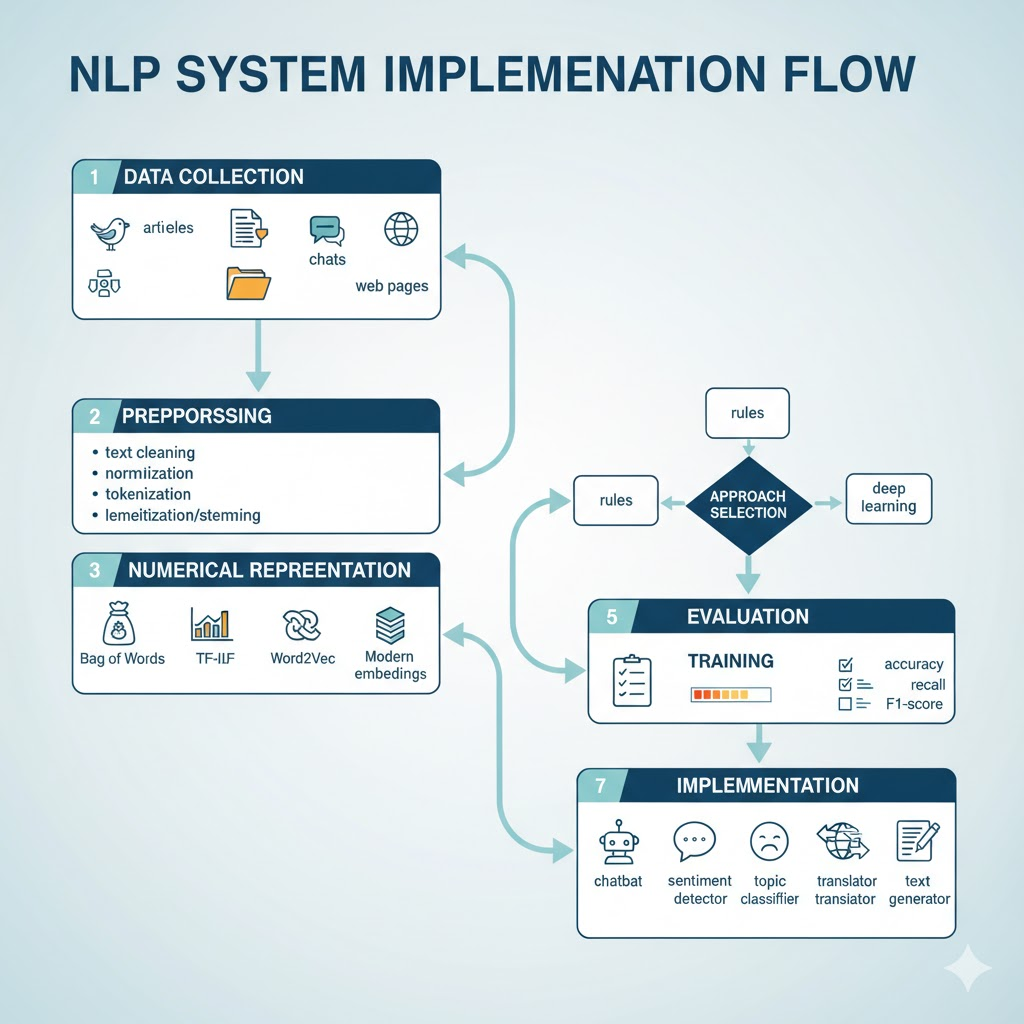


---

## **¿Por qué el Procesamiento del Lenguaje Natural (PLN) es difícil?**

El PLN intenta que las máquinas entiendan el lenguaje humano.  
Pero el lenguaje humano NO es numérico, no es fijo y no es preciso.  
Por eso el PLN presenta varias dificultades.

### **1.1. Los datos no son números, sino lenguaje**

* Las computadoras trabajan con valores numéricos.
* Las palabras son símbolos abstractos sin significado matemático.
* Para poder procesarlas, primero deben convertirse en números (tokens, embeddings, vectores).

**Esto complica el trabajo desde el inicio.**

### **1.2. El lenguaje es ambiguo**

La misma palabra puede significar cosas distintas dependiendo del contexto.

Ejemplos:

* "Banco" → institución financiera o asiento.
* "Llave" → de agua, de puerta, de judo.

Esto se llama **ambigüedad lingüística**.

### **1.3. El lenguaje tiene excepciones**

Algunos grupos de palabras adquieren significados nuevos.

Ejemplos:

* “romper el hielo”
* “tomar el pelo”
* “meter la pata”

Una máquina no puede deducir esto solo con lógica.  
Necesita contexto o aprendizaje previo.

### **1.4. El lenguaje evoluciona constantemente**

* Aparecen nuevas palabras.
* Otras dejan de usarse.
* Los significados cambian con el tiempo.

Los sistemas NLP deben adaptarse continuamente.

---


## **Paradigmas del PLN: cómo ha intentado resolverse históricamente**

**El PLN ha tenido tres grandes enfoques:**

## **Paradigma 1: Enfoque Basado en Reglas**

### **¿Qué es?**

Los lingüistas crean reglas explícitas para que la máquina entienda el lenguaje.

**Ejemplo:**

* Si una palabra termina en “-mente”, es un adverbio.
* Después de “a” puede venir un objeto o destinatario.

### **¿Qué puede hacer?**

* Analizar gramática.
* Identificar funciones sintácticas.

### **Ejemplo usando reglas**

Oración:  

    *“Envía un mensaje a Michael de que llegaré tarde a la reunión.”*

**El sistema basado en reglas:**

* Detecta el verbo “envía”.
* Encuentra un complemento iniciado con “a” → “a Michael”.
* Interpreta “de que llegaré tarde” como subordinada.

### **Ventajas**

* Explicación clara.
* Control total sobre el análisis.

### **Desventajas**

* No se pueden escribir reglas para todos los casos.
* El lenguaje tiene demasiadas excepciones.
* El sistema no aprende: solo sigue reglas predefinidas.

---

## **Paradigma 2: Enfoque Estadístico**

Cuando las reglas ya no fueron suficientes, se introdujo un enfoque más matemático.

### **¿Qué hace?**

**Calcula probabilidades para decidir:**

* El POS (parte del discurso) de una palabra.
* El significado más probable según el contexto.

### **Probabilidad léxica**

Probabilidad de que una palabra tenga un POS:  
P(POS | palabra)

Ejemplo:  

    *“banco” → 70% sustantivo, 30% verbo.*

### **Probabilidad contextual**

Probabilidad de que un POS sea seguido de otro:  
P(POSᵢ | POSᵢ₋₁)

Ejemplo:  

    *Después de un determinante suele venir un sustantivo.*

### **¿Qué hace el sistema?**

Multiplica ambas probabilidades y escoge la interpretación más probable.

### **Ventajas**

* Más flexible que las reglas.
* Maneja variaciones del lenguaje.

### **Desventajas**

* Necesita supervisión humana.
* No capta dependencias largas.
* Limitado por diccionarios y cantidad de datos.

---

## **Paradigma 3: Enfoque Deep Learning**

Este es el enfoque moderno.  

Usa redes neuronales profundas como RNN, LSTM y Transformers.

### **¿Qué hace diferente?**

No analiza palabras aisladas ni reglas explícitas.  
Captura relaciones globales entre palabras dentro de la frase.

Ejemplo:  

    *“El perro que viste ayer estaba enfermo.”*

**Una red neuronal moderna entiende:**

* El sujeto es “el perro”.
* “que viste ayer” es información adicional.
* La idea principal es “estaba enfermo”.

### **Ventajas**

* Maneja dependencias muy largas.
* Capta significado y contexto global.
* Requiere menos reglas humanas.
* Mejora con grandes cantidades de datos.

### **Desventajas**

* Necesita mucho cómputo.
* Requiere grandes datasets.
* Puede equivocarse de forma inesperada.

## **Resumen breve**

| Paradigma         | Cómo funciona                              | Ventajas                             | Desventajas                              |
| ----------------- | ------------------------------------------ | ------------------------------------ | ---------------------------------------- |
| **Reglas**        | Gramática hecha a mano                     | Control total, interpretabilidad     | No escala, demasiadas excepciones        |
| **Estadístico**   | Probabilidades léxicas y contextuales      | Más flexible y realista              | Dependencias cortas, requiere mucho dato |
| **Deep Learning** | Redes neuronales captan contexto global    | Alta precisión, maneja lenguaje real | Costoso, a veces opaco                   |

---

###**EJERCICIO - Enfoque basado en reglas**

In [ ]:
# PARADIGMA 01

import re
import random
import numpy as np

print("="*70)
print("PARADIGMA 1: ENFOQUE BASADO EN REGLAS")
print("="*70)

def analizar_sentimiento_con_reglas(texto):
    """
    Sistema basado en reglas explícitas escritas a mano por humanos.
    NO aprende de datos, solo sigue instrucciones prefijadas.
    """

    # Convertimos el texto a minúsculas para facilitar la búsqueda
    texto = texto.lower()

    # REGLA 1: Si contiene palabras positivas, es positivo
    palabras_positivas = ["excelente", "bueno", "genial", "increíble", "feliz", "amor"]
    for palabra in palabras_positivas:
        if palabra in texto:
            return "POSITIVO (encontré palabra positiva: '{}')".format(palabra)

    # REGLA 2: Si contiene palabras negativas, es negativo
    palabras_negativas = ["malo", "terrible", "horrible", "odio", "triste", "pésimo"]
    for palabra in palabras_negativas:
        if palabra in texto:
            return "NEGATIVO (encontré palabra negativa: '{}')".format(palabra)

    # REGLA 3: Si tiene signos de exclamación múltiples, probablemente es emocional
    if "!!!" in texto:
        return "POSITIVO (tiene múltiples exclamaciones)"

    # REGLA 4: Por defecto, si no cumple ninguna regla, es neutro
    return "NEUTRAL (no cumple ninguna regla específica)"

# Probamos el sistema basado en reglas
oraciones_prueba = [
    "Esta película es excelente",
    "Qué día tan horrible",
    "Hoy es lunes"
]

print("\n Resultados del sistema basado en REGLAS:")
for oracion in oraciones_prueba:
    resultado = analizar_sentimiento_con_reglas(oracion)
    print(f"  '{oracion}' → {resultado}")

PARADIGMA 1: ENFOQUE BASADO EN REGLAS

 Resultados del sistema basado en REGLAS:
  'Esta película es excelente' → POSITIVO (encontré palabra positiva: 'excelente')
  'Qué día tan horrible' → NEGATIVO (encontré palabra negativa: 'horrible')
  'Hoy es lunes' → NEUTRAL (no cumple ninguna regla específica)


###**Características**
- Escrito completamente a mano por humanos"
- Basado en IF-ELSE y listas de palabras"
- NO requiere datos de entrenamiento"
- Fácil de entender pero difícil de escalar"

In [ ]:
# PARADIGMA 02

print("\n" + "="*70)
print("PARADIGMA 2: ENFOQUE ESTADÍSTICO")
print("="*70)

def analizar_sentimiento_estadistico(texto, modelo_entrenado):
    """
    Sistema que APRENDE de ejemplos usando probabilidades.
    Calcula P(positivo|texto) vs P(negativo|texto)
    """

    # Convertimos el texto en palabras individuales
    palabras = texto.lower().split()

    # Calculamos la probabilidad de ser positivo
    prob_positivo = modelo_entrenado['prior_positivo']  # Probabilidad inicial
    for palabra in palabras:
        # Multiplicamos por P(palabra|positivo)
        prob_positivo *= modelo_entrenado['palabras_positivas'].get(palabra, 0.01)

    # Calculamos la probabilidad de ser negativo
    prob_negativo = modelo_entrenado['prior_negativo']  # Probabilidad inicial
    for palabra in palabras:
        # Multiplicamos por P(palabra|negativo)
        prob_negativo *= modelo_entrenado['palabras_negativas'].get(palabra, 0.01)

    # Decidimos según qué probabilidad es mayor
    if prob_positivo > prob_negativo:
        return "POSITIVO (prob={:.4f})".format(prob_positivo)
    else:
        return "NEGATIVO (prob={:.4f})".format(prob_negativo)

# Simulamos un "entrenamiento" con datos históricos
print("\n ENTRENANDO el modelo estadístico con ejemplos...")

# Datos de entrenamiento: textos etiquetados por humanos
datos_entrenamiento = {
    'positivos': ["me encanta esta película", "excelente trabajo", "muy bueno"],
    'negativos': ["odio este producto", "terrible experiencia", "muy malo"]
}

# Creamos el modelo calculando frecuencias de palabras
modelo_estadistico = {
    'prior_positivo': 0.5,  # Asumimos 50% de probabilidad inicial
    'prior_negativo': 0.5,
    'palabras_positivas': {},  # Aquí guardaremos P(palabra|positivo)
    'palabras_negativas': {}   # Aquí guardaremos P(palabra|negativo)
}

# Contamos cuántas veces aparece cada palabra en textos positivos
for texto in datos_entrenamiento['positivos']:
    for palabra in texto.split():
        # Aumentamos el contador de esta palabra en contexto positivo
        modelo_estadistico['palabras_positivas'][palabra] = \
            modelo_estadistico['palabras_positivas'].get(palabra, 0) + 0.3

# Contamos cuántas veces aparece cada palabra en textos negativos
for texto in datos_entrenamiento['negativos']:
    for palabra in texto.split():
        # Aumentamos el contador de esta palabra en contexto negativo
        modelo_estadistico['palabras_negativas'][palabra] = \
            modelo_estadistico['palabras_negativas'].get(palabra, 0) + 0.3

print(f"  - Palabras aprendidas como positivas: {list(modelo_estadistico['palabras_positivas'].keys())}")
print(f"  - Palabras aprendidas como negativas: {list(modelo_estadistico['palabras_negativas'].keys())}")

# Probamos el modelo estadístico
print("\n Resultados del sistema ESTADÍSTICO:")

for oracion in oraciones_prueba:
    resultado = analizar_sentimiento_estadistico(oracion, modelo_estadistico)
    print(f"  '{oracion}' → {resultado}")


PARADIGMA 2: ENFOQUE ESTADÍSTICO

 ENTRENANDO el modelo estadístico con ejemplos...
  - Palabras aprendidas como positivas: ['me', 'encanta', 'esta', 'película', 'excelente', 'trabajo', 'muy', 'bueno']
  - Palabras aprendidas como negativas: ['odio', 'este', 'producto', 'terrible', 'experiencia', 'muy', 'malo']

 Resultados del sistema ESTADÍSTICO:
  'Esta película es excelente' → POSITIVO (prob=0.0001)
  'Qué día tan horrible' → NEGATIVO (prob=0.0000)
  'Hoy es lunes' → NEGATIVO (prob=0.0000)


###**Características**
- APRENDE automáticamente de datos etiquetados"
- Usa probabilidades y matemáticas (Bayes, frecuencias)"
- Necesita muchos ejemplos de entrenamiento"
- Más flexible que reglas, pero interpreta cada palabra independientemente"


In [ ]:
# PARADIGMA 03

print("\n" + "="*70)
print("PARADIGMA 3: ENFOQUE DEEP LEARNING")
print("="*70)

def analizar_sentimiento_deep_learning(texto, red_neuronal):
    """
    Sistema que usa redes neuronales profundas.
    Aprende representaciones automáticas del lenguaje.
    """

    # Paso 1: Convertir texto en números (embedding)
    palabras = texto.lower().split()

    # Cada palabra se convierte en un vector de números
    embeddings = []
    for palabra in palabras:
        # Buscamos la representación vectorial de la palabra
        vector = red_neuronal['embeddings'].get(palabra, [0.1, 0.1, 0.1])
        embeddings.append(vector)

    # Paso 2: Promediamos todos los vectores (representación simple del texto)
    if embeddings:
        vector_texto = np.mean(embeddings, axis=0)
    else:
        vector_texto = np.array([0.0, 0.0, 0.0])

    # Paso 3: Pasamos por la red neuronal (capas de transformación)

    # Capa 1: transformación con pesos aprendidos
    capa1 = np.dot(vector_texto, red_neuronal['pesos_capa1'])
    capa1 = np.maximum(0, capa1)  # Función de activación ReLU

    # Capa 2: salida final
    salida = np.dot(capa1, red_neuronal['pesos_capa2'])

    # Paso 4: Interpretamos el resultado
    probabilidad_positivo = 1 / (1 + np.exp(-salida[0]))  # Función sigmoide

    if probabilidad_positivo > 0.5:
        return "POSITIVO (confianza={:.2%})".format(probabilidad_positivo)
    else:
        return "NEGATIVO (confianza={:.2%})".format(1-probabilidad_positivo)

# Simulamos una red neuronal "pre-entrenada"
print("\n INICIALIZANDO red neuronal profunda...")

# La red neuronal tiene capas con pesos que se aprendieron de millones de textos
red_neuronal = {
    # Embeddings: representaciones vectoriales de palabras aprendidas
    'embeddings': {
        'excelente': [0.9, 0.8, 0.1],
        'bueno': [0.7, 0.6, 0.2],
        'genial': [0.85, 0.75, 0.15],
        'horrible': [-0.8, -0.7, 0.9],
        'terrible': [-0.9, -0.85, 0.95],
        'malo': [-0.7, -0.6, 0.8],
        'película': [0.1, 0.2, 0.3],
        'día': [0.0, 0.1, 0.2],
        'esta': [0.05, 0.05, 0.05],
        'es': [0.05, 0.05, 0.05],
        'qué': [0.0, 0.0, 0.1],
        'tan': [0.05, 0.05, 0.05],
        'hoy': [0.0, 0.1, 0.1],
        'lunes': [0.0, 0.0, 0.2]
    },
    # Pesos de las capas neuronales (aprendidos con backpropagation)
    'pesos_capa1': np.array([[2.5, -1.2], [2.3, -1.0], [-2.0, 2.8]]),
    'pesos_capa2': np.array([[3.0], [-3.2]])
}

print("  - Embeddings cargados para {} palabras".format(len(red_neuronal['embeddings'])))
print("  - Red con 2 capas ocultas")
print("  - Pesos aprendidos de millones de ejemplos")

# Probamos la red neuronal
print("\n Resultados del sistema DEEP LEARNING:")
for oracion in oraciones_prueba:
    resultado = analizar_sentimiento_deep_learning(oracion, red_neuronal)
    print(f"  '{oracion}' → {resultado}")


PARADIGMA 3: ENFOQUE DEEP LEARNING

 INICIALIZANDO red neuronal profunda...
  - Embeddings cargados para 14 palabras
  - Red con 2 capas ocultas
  - Pesos aprendidos de millones de ejemplos

 Resultados del sistema DEEP LEARNING:
  'Esta película es excelente' → POSITIVO (confianza=96.12%)
  'Qué día tan horrible' → NEGATIVO (confianza=98.13%)
  'Hoy es lunes' → NEGATIVO (confianza=69.45%)


###**LA GRAN DIFERENCIA:**

**REGLAS:** "Yo te digo exactamente qué hacer paso por paso"
   - Como darle instrucciones a un robot muy literal
   - Si no escribiste la regla, no puede manejarlo
   
**ESTADÍSTICO:** "Aprendo de ejemplos y calculo probabilidades"
   - Como un estudiante que memoriza patrones
   - Puede generalizar un poco, pero trata palabras independientemente
   
**DEEP LEARNING:** "Aprendo representaciones complejas automáticamente"
   - Como un experto que entiende contexto y matices
   - Puede capturar relaciones profundas entre palabras

####**EVOLUCIÓN HISTÓRICA:**

      Reglas (1950s) → Estadístico (1990s) → Deep Learning (2012+)
    
**Cada paradigma RESOLVIÓ las limitaciones del anterior:***

- Reglas eran demasiado rígidas → Estadístico añadió aprendizaje
- Estadístico no capturaba contexto → Deep Learning usa representaciones ricas

**HOY EN DÍA:**

> Deep Learning domina, pero a veces se combinan los 3!
   (Por ejemplo: ChatGPT usa Deep Learning + reglas de seguridad)



---



## **Datos Secuenciales**

### **1. ¿Qué son los datos con propiedad temporal?**

Los datos con propiedad temporal son datos cuya información depende del tiempo, y donde el orden importa.

**En otras palabras:**

- No puedes mezclar los valores.

- Un valor tiene significado porque viene después o antes de otro.

**Ejemplos reales:**

- Señales de ECG (latidos del corazón a través del tiempo)
- Precios de acciones (varían cada segundo o cada día)
- Señal de voz humana (ondas que cambian a lo largo del tiempo)
- Frases y textos (las palabras forman un significado secuenciado)
- Secuencias de ADN (caracteres ordenados que definen funciones biológicas)

---

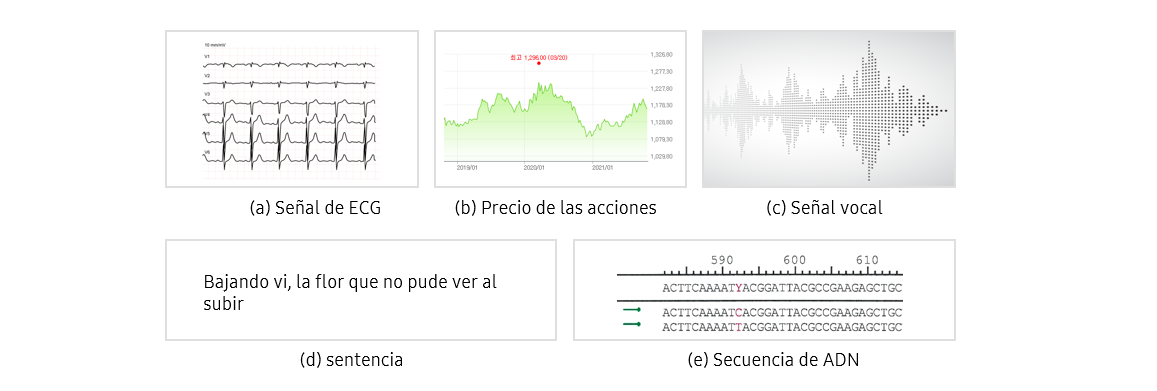

---

## **2. Ejemplos visuales de datos secuenciales**

### **(a) Señal de ECG**

* Una señal eléctrica donde cada pico corresponde a un latido.  

Interesa el orden de los picos, no solo su valor.

.

### **(b) Precio de acciones**

* El precio a las 10:00 es diferente del de las 10:05, y la tendencia importa más que un valor aislado.

.

### **(c) Señal vocal**

La voz es una señal continua donde cada microsegmento depende del anterior.  
Por ejemplo, un "aaa" tiene una forma reconocible en ondas.

.

### **(d) Frases o sentencias**

Ejemplo:

* “Bajando vi, la flor que no pude ver al subir”

* El significado se pierde si cambias el orden:

* “La flor vi, al bajando pude no subir que”

* En texto, el orden ES el significado.

.

### **(e) Secuencia de ADN**

Ejemplo:

> ACTTCAAAATYACGGAT...

Cambiar una letra o el orden cambia completamente la función genética.  
También es un tipo de secuencia.

---

.

## **3. Características fundamentales de los datos temporales**

**Estos datos:**

**1. Son dinámicos**  
Cambian con el tiempo (día 1 ≠ día 2).

**2. Tienen una relación entre sus valores**  
Lo que ocurre en t=5 depende de t=4.

**3. Pueden tener longitudes variables**

Ejemplo:

- ECG: 500 puntos  
- Otra señal: 2000 puntos  
- Frase de 7 palabras  
- Frase de 30 palabras  

No siempre tienen la misma longitud.

.

## **4. ¿Por qué las secuencias requieren modelos especiales?**

Porque una secuencia NO es solo una lista de números.  
Es información conectada en el tiempo.

Para obtener buen rendimiento, debemos usar modelos que tengan:

- memoria
- capacidad de entender contexto
- capacidad de relacionar valores alejados

.

## **5. La herramienta clásica: RNN (Red Neuronal Recurrente)**

Las RNN fueron diseñadas para procesar datos secuenciales porque:

- Reciben un dato  
- Recuerdan el anterior  
- Procesan la secuencia completa

Ideal para:

- voz  
- texto  
- series temporales  

Pero…

.

## **6. El problema: dependencia a largo plazo**

En una frase grande como:

“El gato que viste ayer… era mío.”

Para entender la frase, debes saber que:

“era mío” se refiere a “el gato”  
y esas palabras están muy separadas.

.

Esto se llama **dependencia a largo plazo**:

La relación entre elementos muy distantes.

Las RNN estándar no pueden manejar bien esas distancias.

.

## **7. La solución: LSTM (Long Short-Term Memory)**

La LSTM es una mejora de la RNN.

**Su gran ventaja:**

**Tiene memoria selectiva**

Es decir, puede decidir:

- qué información recordar mucho tiempo
- qué olvidar rápidamente
- qué actualizar

Por eso puede manejar secuencias largas.

**Ejemplo:**

Los traductores automáticos hoy procesan frases de 30+ palabras gracias a LSTM.  

Antes solo se podían traducir frases cortas (máximo 10 palabras).

.

## **8. Memoria selectiva (idea simple)**

La LSTM actúa como un sistema de memoria que dice:

“Esto sí es importante → lo guardo”  
“Esto es ruido → lo borro”  
“Esto es nuevo → lo añado a mi memoria”

**Por eso:**

- recuerda lo que importa  
- ignora lo que no  

.

## **RESUMEN**

- Los datos secuenciales (temporales) aparecen en voz, ECG, ADN, texto, finanzas.  
- Requieren modelos que entiendan el orden y el tiempo.  
- Las RNN procesan secuencias, pero fallan con dependencias largas.  
- Las LSTM solucionan esto gracias a su memoria selectiva.


## **Corpus**

Se refiere a un conjunto de datos de texto sujetos a analisis.

**a) Corpus bruto:** datos de texto almacenados en una base de datos.

**b) Corpus etiquetado:** datos de texto en los que las palabras y las frases se han etiquetado segun un modelo.

---

###**¿Qué es un corpus bruto?**

Es simplemente texto sin limpiar y sin información adicional.
- Tiene errores, ruido, signos raros, URLs… tal como se encuentra.

In [ ]:
corpus_bruto = [
    "RT @usuario1: La IA es el futuro!!! https://t.co/asd123 #tecnología",
    "Los coches   eléctricos   serán comunes   en 2030???",
    "COMPRA YA!!! DESCUENTOS increíbleS >>> www.ofertas.com",
    "Ayer fui al cine y la película estuvo MUY buena!!!"
]

print(corpus_bruto)


['RT @usuario1: La IA es el futuro!!! https://t.co/asd123 #tecnología', 'Los coches   eléctricos   serán comunes   en 2030???', 'COMPRA YA!!! DESCUENTOS increíbleS >>> www.ofertas.com', 'Ayer fui al cine y la película estuvo MUY buena!!!']


####**Características:**

- Puede tener caracteres basura

- Incluye hashtags, emojis, URLs, repeticiones

- No está segmentado ni limpiado

- No tiene etiquetas (clases, categorías, etc.)

.

**¿Para qué sirve?**

Sirve como material de origen para un proyecto de PLN (Procesamiento del Lenguaje Natural).

**Luego tienes que limpiarlo para usarlo.**

---

###**¿Qué es un corpus etiquetado?**

Es un corpus donde cada texto tiene una etiqueta (categoría, clase, valor, sentimiento, tema…).

In [ ]:
corpus_etiquetado = [
    ("La IA es el futuro", "tecnología"),
    ("Los coches eléctricos serán comunes pronto", "automoción"),
    ("Gran película, me encantó", "opinión_positiva"),
    ("No me gustó el servicio", "opinión_negativa")
]

for texto, etiqueta in corpus_etiquetado:
    print(f"Texto: {texto}  →  Etiqueta: {etiqueta}")


Texto: La IA es el futuro  →  Etiqueta: tecnología
Texto: Los coches eléctricos serán comunes pronto  →  Etiqueta: automoción
Texto: Gran película, me encantó  →  Etiqueta: opinión_positiva
Texto: No me gustó el servicio  →  Etiqueta: opinión_negativa


####**Características:**

- Cada texto tiene una categoría asignada

- Es limpio o casi limpio

- Es MUY valioso para entrenamiento de modelos

.

**¿Para qué sirve?**

**Entrenar modelos supervisados, como:**

- Clasificación de texto

- Análisis de sentimiento

- Detección de temas

- Sistemas de recomendación

**Sin corpus etiquetado, no puedes entrenar modelos supervisados.**

---

###**DIFERENCIAS**

| Corpus bruto                           | Corpus etiquetado                            |
| -------------------------------------- | -------------------------------------------- |
| Texto original sin limpiar             | Texto limpio o procesado                     |
| No tiene categorías                    | Cada texto tiene una etiqueta                |
| Incluye ruido (RT, URLs, emojis, etc.) | Información estructurada                     |
| Fase inicial                           | Fase preparada para análisis o entrenamiento |
| Útil para análisis exploratorio        | Útil para machine learning                   |


---

###**Como convertimos un corpus bruto a uno limpio?**

In [ ]:
import re

corpus_bruto = [
    "RT @user: Me ENCANTÓ la película!! #cine",
    "La comida estuvo terrible... nunca más ",
]

def limpiar(texto):
    texto = texto.lower()                       # todo en minúsculas
    texto = re.sub(r"http\S+", "", texto)       # quitar URLs
    texto = re.sub(r"@\w+", "", texto)          # quitar usuarios
    texto = re.sub(r"#\w+", "", texto)          # quitar hashtags
    texto = re.sub(r"[^a-záéíóúñ ]", "", texto) # quitar símbolos
    texto = re.sub(r"\s+", " ", texto)          # limpiar espacios
    return texto.strip()

corpus_limpio = [limpiar(t) for t in corpus_bruto]
print(corpus_limpio)

print('*'*50)

corpus_etiquetado = [
    (corpus_limpio[0], "positivo"),
    (corpus_limpio[1], "negativo")
]

print(corpus_etiquetado)


['rt me encantó la película', 'la comida estuvo terrible nunca más']
**************************************************
[('rt me encantó la película', 'positivo'), ('la comida estuvo terrible nunca más', 'negativo')]


---

###**QUE UTILIDAD TIENE CADA UNO?**

**Corpus bruto**

**Sirve para:**

- Extraer vocabulario

- Estudiar el estilo del texto

- Encontrar ruido

- Probar métodos de limpieza

---

**Corpus limpio**

**Sirve para:**

- Crear diccionarios

- Generar matrices término-documento

- Hacer extracción de términos

- Aplicar TF-IDF

- Procesos automáticos

---

**Corpus etiquetado**

**Sirve para entrenar modelos de Machine Learning:**

- Clasificador de sentimientos

- Clasificador de temas

- Modelo que detecte spam

- Modelo que analice opiniones

**Es el más valioso, porque lleva trabajo humano.**

---

# **PREPROCESAMIENTO DE TEXTOS**

##**Tokenización**

La tokenización es el primer paso para procesar texto. Consiste en dividir un texto en unidades más pequeñas llamadas tokens (fichas), que suelen ser palabras o caracteres.

* Esto hace el texto más manejable para una máquina.

Por ejemplo, partir la frase “¿Cómo estás?” en tokens sería como separar un bloque de texto en piezas más pequeñas, tal como un chef corta ingredientes en trozos antes de cocinar.

> Como dice DataCamp, “la tokenización convierte una secuencia de texto en partes más pequeñas... para ayudar a las máquinas a comprender el lenguaje humano”

.

> ***En términos sencillos, es como enseñar a un niño a leer separando primero letras, luego sílabas y finalmente palabras***

.

####**¿Para qué se usa?:**

**Casi todos los algoritmos de PLN necesitan tokens como entrada.**

Por ejemplo, un modelo de clasificación de texto primero tokeniza cada oración en palabras para luego analizarlas.

* También se usa en motores de búsqueda (para indexar palabras clave) y en traductores automáticos (para traducir frase por frase).

En general, es el “corte” inicial del texto que permite reconocer patrones.

.

###**Tipos de tokenización**

Podemos separar por...

* Palabras (el método más común, usando espacios en idiomas con límites claros entre palabras).

* Por caracteres (útil en lenguas sin espacios o en análisis de ortografía).

* Por subpalabras (porciones intermedias, como “Chat” y “bots” de “Chatbots”).

**Cada método sirve para diferentes propósitos.**

.

**Por ejemplo**, la tokenización de caracteres es clave en idiomas sin separadores claros, mientras la de subpalabras ayuda con palabras nuevas o muy largas

.

**Ejemplo:**

Consideremos la frase en español:

    "¡Hola, mundo! ¿Cómo están?"


**Una tokenización sencilla por espacios (palabras) produciría algo como:**

    ["¡Hola,", "mundo!", "¿Cómo", "están?"]


Vemos que incluye signos de puntuación adyacentes. Para refinamientos extra (como separar “¡” y “?”) usaríamos herramientas especializadas.

**Ejemplo con Python:**

Usando NLTK (biblioteca de PLN) podemos tokenizar fácilmente. Por ejemplo:

In [ ]:
from nltk.tokenize import word_tokenize
import nltk


texto = "¡Hola, mundo! ¿Cómo están todos?"
# Tokenización básica: separar por espacios

tokens_basico = texto.split()
print("Tokens (split básico):", tokens_basico)

# Tokenización con NLTK (más sofisticada)

nltk.download('punkt_tab')  # Descarga el modelo de tokenización en español
tokens_nltk = word_tokenize(texto, language='spanish')
print("Tokens (NLTK):", tokens_nltk)

Tokens (split básico): ['¡Hola,', 'mundo!', '¿Cómo', 'están', 'todos?']
Tokens (NLTK): ['¡Hola', ',', 'mundo', '!', '¿Cómo', 'están', 'todos', '?']


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


**Que hicimos?:**

1. Primero usamos split() de Python para ilustrar la división básica (aunque no separa bien los signos).

2. Luego importamos word_tokenize de NLTK, que maneja mejor la puntuación. Nótese que descargamos el modelo 'punkt' para tokenizar en español.

3. Finalmente tokens_nltk contendrá una lista de palabras y signos separados correctamente.

Esto muestra cómo pasar de un string (“¡Hola, mundo! …”) a una lista de tokens. La tokenización es esencial porque sin ella no podemos seguir procesando el texto. En el flujo de trabajo de PLN, este paso precede siempre a cualquier análisis posterior (extracción de características, etiquetado, etc.).


##**Palabras clave**

Las palabras clave son términos significativos o representativos en un texto. Identificarlas es útil para resumir contenido, indexarlo o entender de qué trata un documento.

> **Para extraer palabras clave, normalmente primero limpias el texto (tokenizando y, por ejemplo, eliminando palabras muy comunes, llamadas stop words).**

.

Las stop words (como “el”, “y”, “de”) son palabras frecuentes que aportan poco significado. Eliminar estas palabras ayuda a centrarse en lo importante

.

**Por ejemplo, de la frase:**

*“El gato come pescado”*

La palabra clave sería “gato” y “pescado”, no “el” o “come”.

.

####**¿Cómo funcionan?**

1. Una técnica sencilla consiste en contar la frecuencia de cada palabra relevante.

2. Primero tokenizamos el texto, convertimos a minúsculas y quitamos puntuación. Luego eliminamos stop words.

3. Con las palabras restantes, calculamos qué tan frecuentes son.

4. Las que aparecen más veces suelen considerarse palabras clave.

5. Por ejemplo, TF-IDF es un método avanzado para esto: da más peso a las palabras frecuentes en un documento pero raras en otros.

6. En grandes colecciones, TF-IDF “ayuda a identificar palabras clave y temas predominantes”

.

####**Ejemplo:**

**Supongamos el texto:**


*"El gato negro come pescado fresco. El gato negro bebe leche fresca."*


* Tokens (tras limpiar): ["gato","negro","come","pescado","fresco","gato","negro","bebe","leche","fresca"]

* Quitando stop words y normalizando (“fresco” vs “fresca” idealmente igualando): nos quedan palabras como “gato”, “negro”, “come”, “pescado”, “bebe”, “leche”.

* **Frecuencia:** “gato” (2), “negro” (2), otras (1). Por frecuencia, “gato” y “negro” serían palabras clave principales.

.


####**Ejemplo con Python:**

Podemos usar NLTK para ilustrar extracción básica de palabras clave mediante frecuencia:



In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Descargar recursos necesarios (incluyendo punkt_tab)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

texto = "La inteligencia artificial y el aprendizaje automático son útiles. La inteligencia es la base."

# 1. Tokenizar y pasar a minúsculas
tokens = word_tokenize(texto.lower(), language='spanish')
print("** Tokens originales:", tokens)

# 2. Eliminar palabras vacías (stopwords) y signos no alfabéticos
stop = set(stopwords.words('spanish'))
tokens_limpios = [t for t in tokens if t.isalpha() and t not in stop]
print("** Tokens filtrados:", tokens_limpios)

# 3. Contar frecuencia
freq = Counter(tokens_limpios)
print("** Frecuencias:", freq)
print("** Palabras clave (más frecuentes):", freq.most_common(2))
print('-'*130)

** Tokens originales: ['la', 'inteligencia', 'artificial', 'y', 'el', 'aprendizaje', 'automático', 'son', 'útiles', '.', 'la', 'inteligencia', 'es', 'la', 'base', '.']
** Tokens filtrados: ['inteligencia', 'artificial', 'aprendizaje', 'automático', 'útiles', 'inteligencia', 'base']
** Frecuencias: Counter({'inteligencia': 2, 'artificial': 1, 'aprendizaje': 1, 'automático': 1, 'útiles': 1, 'base': 1})
** Palabras clave (más frecuentes): [('inteligencia', 2), ('artificial', 1)]
----------------------------------------------------------------------------------------------------------------------------------


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Comentarios del código:**

Descargamos listas de stop words en español.

tokens_limpios elimina palabras comunes y no alfabéticas.

Usamos Counter para contar cuántas veces aparece cada palabra.

Finalmente mostramos las dos palabras con mayor frecuencia, que serían consideradas palabras clave.

En este ejemplo, “inteligencia” aparece dos veces, mientras la mayoría aparecen solo una vez. Así “inteligencia” sería identificada como palabra clave.

> **Importante:** Identificar palabras clave ayuda en tareas como resumen automático o motores de búsqueda. Al centrarnos en las palabras más relevantes, mejoramos la calidad del análisis de texto

**Por ejemplo, para indexar documentos un motor de búsqueda ignora palabras comunes y usa las palabras clave para encontrar temas similares.**




---



###**Lematización y Stemming**

A veces distintos tokens son variaciones de una misma palabra. Stemming y lematización son técnicas que transforman palabras a su forma base. La forma base o raíz elimina sufijos (y a veces prefijos) para que variantes como “corriendo”, “corrí”, “corre” puedan compararse mejor.

**Stemming**

Usa reglas sencillas para recortar finales. Por ejemplo, el algoritmo de Porter (en inglés) o Snowball (mejora de Porter). Estos algoritmos eliminan sufijos sin considerar contexto lingüístico. Ventaja: son rápidos; desventaja: a veces cortan demasiado, produciendo cadenas que no son palabras reales (“camin” de “caminando”).

.

**Lematización**

Consiste en usar un diccionario o conocimiento gramatical para convertir cada palabra a su lema (la forma de diccionario). Por ejemplo, el lema de “corriendo” es “correr”. Esto toma en cuenta la categoría gramatical (un verbo no se reduce igual que un sustantivo). La lematización suele requerir más recursos (diccionarios, modelos), pero produce resultados más precisos que el stemming.

**Ejemplo de funcionamiento: Para el español, el stemmer Snowball puede recortar palabras:**

In [ ]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('spanish')
palabras = ["caminando", "camino", "caminé", "caminas"]
for w in palabras:
    print(w, "->", stemmer.stem(w))

caminando -> camin
camino -> camin
caminé -> camin
caminas -> camin


El stemmer recorta todos esos verbos a la raíz “camin”. Como se ve, “camin” no es una palabra completa en español, pero ayuda a agrupar todas esas formas.

.

**Para la lematización en español es más complejo**, pues NLTK básico no trae un lematizador en español. Se suele usar librerías como spaCy o Pattern. Por ejemplo:

In [ ]:
import spacy
nlp = spacy.load("es_core_news_sm")
doc = nlp("Corriendo camina camino corre")
for token in doc:
    print(token.text, "->", token.lemma_)

####**¿Para qué se usan?**

**Ambas técnicas ayudan a normalizar el texto.**

**Por ejemplo**, en buscadores convierte distintas formas de una palabra en la misma raíz, mejorando coincidencias de búsqueda

En análisis de sentimientos o clasificación de texto, reduce el número de “palabras diferentes” y agrupa sentimientos asociados a la misma raíz.

> *“Al reducir las palabras a sus formas base, se mejora la consistencia y precisión en la clasificación de documentos”*

**Se suele elegir stemming cuando importa la velocidad y no tanto la perfección, y lematización cuando necesitamos resultados más exactos**

.

####**Analogía**

Podemos pensar en el stemming como si cortáramos las hojas y tallos de diferentes flores para quedarnos solo con el tallo común; mientras que lematización sería identificar cada flor por su especie exacta usando un manual de botánica. Ambos buscan agrupar palabras relacionadas.

---



###**Etiquetado POS (Part-of-Speech Tagging)**

El etiquetado POS asigna a cada palabra de un texto una etiqueta gramatical, por ejemplo sustantivo, verbo, adjetivo, etc. Esto ayuda a entender la función de cada palabra en la oración. Según AWS, “el etiquetado de categorías gramaticales etiqueta palabras individuales en una oración de acuerdo con los usos contextuales, como sustantivos, verbos, adjetivos o adverbios”.

En otras palabras, un etiquetador POS dice “esto es un verbo”, “esto es un adjetivo”, lo que permite que la máquina comprenda mejor la estructura y el significado de la frase.

####**¿Cómo funciona?**

Después de tokenizar el texto, un modelo de POS analiza cada token y lo clasifica.

**Por ejemplo, en la frase “El perro ladra fuerte”**

* “El”→DET (determinante).

* “perro”→NOUN (sustantivo).

* “ladra”→VERB (verbo).

* “fuerte”→ADV (adverbio).

Este etiquetado usualmente requiere modelos previamente entrenados (muchos en inglés, algunos en español como spaCy o modelos específicos).

.

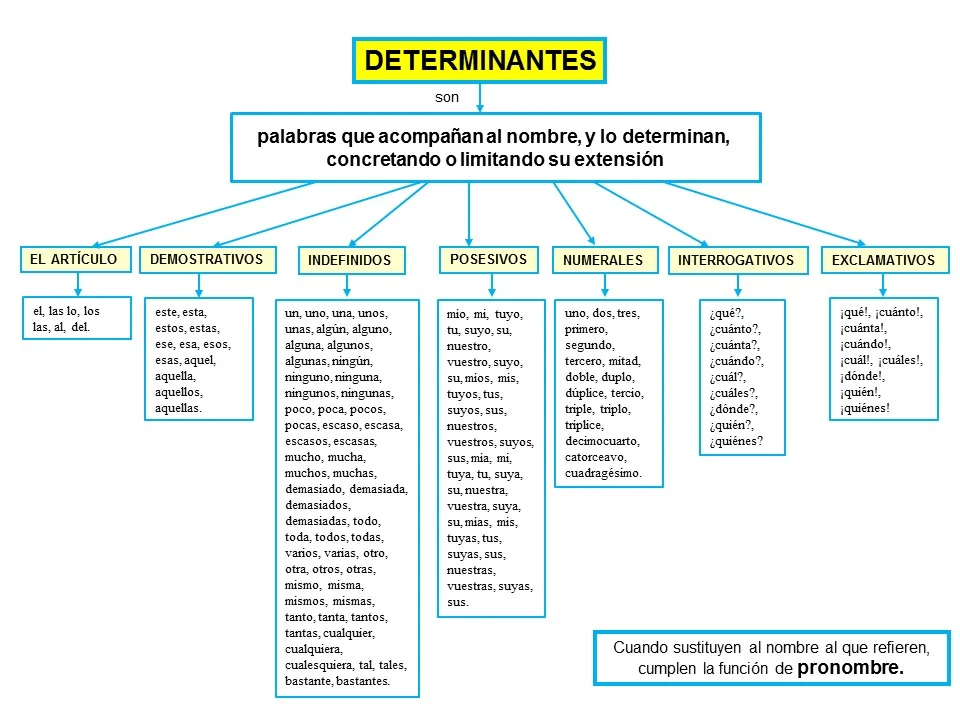

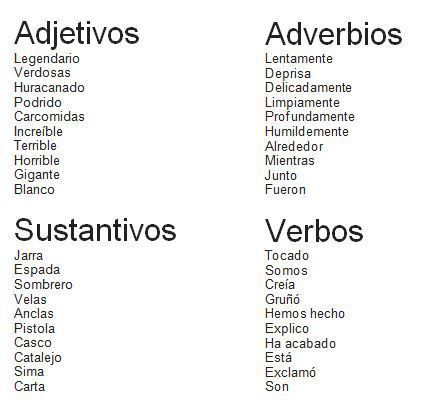

####**Ejemplo con Python:**

En inglés NLTK tiene un etiquetador por defecto. En español podemos usar spaCy si está instalado. Ejemplo con spaCy (requiere modelo español):

In [ ]:
import spacy
# nlp = spacy.load("es_core_news_sm")  # Descomente y asegúrese de haber instalado el modelo de español

doc = nlp("Mar\u00eda come manzanas y zanahorias.")  # Frase de ejemplo
for token in doc:
    print(token.text, "->", token.pos_)

**Comentarios del código:**

* token.text es la palabra original, token.pos_ es su etiqueta POS (por ejemplo NOUN, VERB, etc.).

* Este código procesaría la frase completa y mostraría algo como:

---

**María -> PROPN, come -> VERB, manzanas -> NOUN, y -> CCONJ, zanahorias -> NOUN, . -> PUNCT. (Dependiendo del modelo de spaCy).**

---

* El etiquetado POS es fundamental en tareas de análisis sintáctico, extracción de entidades y comprensión de oraciones. Por ejemplo, ayuda a diferenciar “banco” (sustantivo) de “banco” (verbo) según el contexto, o a entender quién hace qué en una frase.

---

###**Codificación de números enteros**

Los modelos de aprendizaje automático no entienden palabras, solo números. La codificación entera asigna a cada token (por ejemplo cada palabra del vocabulario) un número único, de esta forma, una frase se convierte en una secuencia de números.

Por ejemplo, si nuestro vocabulario asigna “hola”→1, “mundo”→2, entonces la frase “hola mundo hola” sería la secuencia [1, 2, 1].

Como explica un manual de Keras en español, “cada palabra en el vocabulario se asigna un número entero único y las secuencias de palabras se sustituyen por secuencias de números enteros”

Este paso es esencial para alimentar las redes neuronales, ya que requieren datos numéricos.

.

####**¿Cómo funciona?**

1. Primero tokenizamos el texto y construimos un vocabulario (lista de palabras únicas).

2. Luego creamos un diccionario (o usamos una herramienta) que da a cada palabra un índice numérico, por ejemplo por orden de frecuencia (palabra más común = 1, siguiente = 2, etc.).

3. Finalmente, reemplazamos cada token en nuestro texto por su índice.

####**Ejemplo sin Python**

Supongamos el vocabulario: {“gato”:1, “come”:2, “pescado”:3}.

Entonces la frase “El gato come pescado” (tras quitar stop words) quedaría codificada como [1, 2, 3].


####**Ejemplo con Python:**

Aquí un ejemplo simple construyendo manualmente el diccionario:

In [ ]:
tokens = ["hola", "mundo", "hola", "adios"]
# Crear vocabulario asignando índices
vocab = {}
encoded = []
for w in tokens:
    if w not in vocab:
        vocab[w] = len(vocab) + 1  # Asigna 1, luego 2, etc.
    encoded.append(vocab[w])
print("Diccionario (palabra->índice):", vocab)
print("Secuencia codificada:", encoded)

Diccionario (palabra->índice): {'hola': 1, 'mundo': 2, 'adios': 3}
Secuencia codificada: [1, 2, 1, 3]


**Comentarios del código:**

* Iniciamos con tokens, una lista de palabras.

* Recorremos cada palabra w; si no está en vocab, la agregamos con un nuevo número, encoded acumula la secuencia de índices.

* Al final vocab podría ser {'hola': 1, 'mundo': 2, 'adios': 3} y la frase codificada sería [1, 2, 1, 3].

**También existen herramientas que automatizan esto.**

Por ejemplo, Keras tiene Tokenizer que puede convertir textos a secuencias enteras automáticamente, pero el concepto básico es siempre el mismo:

    "reemplazar palabras por números."

Como resumen, “el Tokenizer asigna un índice único a cada palabra en el vocabulario”, permitiendo luego convertir oraciones en listas de enteros.

---

###**Relleno (Padding)**

Tras codificar oraciones en secuencias numéricas, cada secuencia puede tener distinta longitud. Sin embargo, muchos modelos (especialmente redes neuronales) requieren que todas las secuencias tengan la misma longitud, para procesarlas por lotes. El padding o relleno consiste en agregar ceros (u otro valor neutro) al principio o al final de cada secuencia para igualar la longitud al máximo deseado. Como explica un recurso de Keras en español: “el relleno implica agregar ceros al principio o al final de las secuencias para que todas tengan la misma longitud, lo que permite procesar lotes de datos de manera eficiente.”
imaster.academy
.

**¿Cómo funciona?:**

1. Primero decidimos una longitud fija (por ejemplo la longitud de la secuencia más larga, o un máximo predefinido).

2. Luego, para cada secuencia más corta que esa, agregamos ceros al inicio (padding='pre') o al final (padding='post') hasta alcanzar la longitud deseada.

3. Si una secuencia es más larga que el máximo, podemos truncarla (cortar los valores extras).

**Ejemplo sin Python:**

Supongamos dos secuencias codificadas: [1, 5, 3] (longitud 3) y [4, 2] (longitud 2).

Si queremos que ambas tengan longitud 4 (por ejemplo), podemos hacer padding al final:

[1, 5, 3] ⇒ [1, 5, 3, 0] (agregamos un 0)

[4, 2] ⇒ [4, 2, 0, 0] (agregamos dos 0)
Ahora ambas miden 4.

###**Ejemplo con Python**

In [ ]:
sequences = [[10, 20, 30], [7, 8]]
# Encontrar longitud máxima
max_len = max(len(s) for s in sequences)
padded_seqs = []
for seq in sequences:
    # Rellenar con ceros al final
    padded = seq + [0]*(max_len - len(seq))
    padded_seqs.append(padded)
print("Secuencias originales:", sequences)
print("Secuencias con padding:", padded_seqs)


**Comentarios del código:**

* Calculamos max_len = 3.

* La primera secuencia ya es de longitud 3, así que añadimos 0 ceros: [10,20,30].

* La segunda secuencia [7,8] es más corta (longitud 2), agregamos un cero al final para hacerla longitud 3: [7,8,0].

* Las nuevas secuencias sí tienen todas la misma longitud (3 en este caso).

* El padding facilita procesar datos por lotes (batch) en modelos de deep learning. Sin él, no podríamos combinar ejemplos de distintas longitudes en una única entrada matricial.

* Por ello, después de codificar enteros, casi siempre aplicamos padding.

---

###**Codificación en caliente (One-Hot Encoding)**

La codificación one-hot es una forma de representar categorías (como palabras o clases) con vectores binarios.

Cada categoría se convierte en un vector donde una posición es 1 y las demás 0. Por ejemplo, si tenemos 4 palabras en el vocabulario con índices 0,1,2,3, entonces: índice 2 sería el vector [0, 0, 1, 0].

De esta forma, ninguna información queda “codificada en un solo número” (como el entero), sino distribuida en un vector binario.

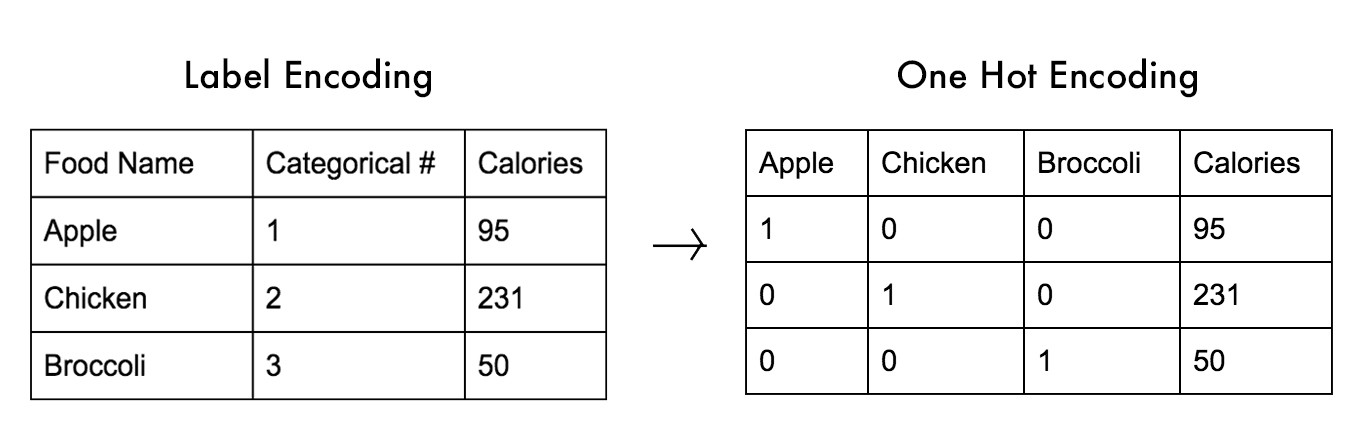


###**¿Para qué se usa?**

* En PLN se suele usar one-hot para representar salidas o etiquetas de categorías, especialmente si el vocabulario es pequeño o se requiere una distribución discreta.

* Por ejemplo, en un clasificador con N clases de texto, la etiqueta de la clase i se codificaría como un vector con 1 en la posición i.

* También se puede usar en palabras, aunque con vocabularios grandes el vector resultante sería muy grande (por eso a veces solo se usa enteros para entradas y one-hot para salidas).

* En el contexto de secuencias, [15] explica que tras codificar secuencias en enteros, éstas “tendrían que ser codificadas en caliente” para representar la distribución de probabilidad sobre el vocabulario
unipython.com
.

####**Ejemplo:**

**Supongamos 5 palabras posibles (vocabulario de tamaño 5).**

* Las codificamos del 0 al 4.

* El one-hot de la palabra con índice 3 sería:

**[0, 0, 0, 1, 0]**


Solo la tercera posición (índice 3) es 1; las demás son 0. Cada entero tiene así un vector único.

####**Ejemplo con Python: Podemos crear un vector one-hot manualmente:**

In [ ]:
def one_hot(index, vocab_size):
    vec = [0]*vocab_size
    vec[index] = 1
    return vec

print(one_hot(2, 5))  # Vocabulario de tamaño 5, índice 2

**Aquí hemos creado un vector de ceros de longitud 5 y pusimos un 1 en la posición index=2. Así es como se ve un one-hot encoding para la categoría 2 en un vocabulario de 5.**

* Con librerías, también existe to_categorical en Keras que hace lo mismo.

* Lo importante es entender que cada entero se convierte en un vector binario, con un “uno” en su posición.

* Esto suele usarse en la capa de salida de redes neuronales (por ejemplo, en clasificación de texto, la salida deseada es un one-hot del número de clase).

---

####**Conexión de conceptos: Pipeline de preprocesamiento**

En conjunto, estos pasos conforman un pipeline progresivo de preprocesamiento de texto:

* **Tokenización:** divide el texto en tokens (palabras).

* **Limpieza/Palabras clave:** se eliminan stop words o símbolos irrelevantes, quedándonos con las palabras clave del mensaje.

* **Lematización/Stemming:** normalizamos cada token a su raíz o lema para agrupar variantes de palabras.

* **Etiquetado POS (opcional):** obtenemos la función gramatical de cada palabra para tareas avanzadas.

* **Codificación entera:** convertimos tokens (p. ej. palabras) en enteros únicos.

* **Padding:** rellenamos con ceros las secuencias numéricas para igualar su longitud.

* **One-Hot Encoding (si es necesario):** convertimos cada entero a un vector binario para representar categorías.

.

**Así, de un texto como**

    *“El perro come”*

.

**Obtenemos finalmente algo así:**

tokens → [perro, come] → (sin stopwords) [perro, come] → (stem) [perr, com] → (enteros) [1, 2] → (padding) [1, 2, 0] → (one-hot) [[1,0,0],[0,1,0],[0,0,0]] (si fuera necesario).

Cada paso aporta claridad o forma adecuada para el modelo de IA. Estos procesos, combinados, permiten transformar texto libre en datos estructurados que las máquinas pueden entender.

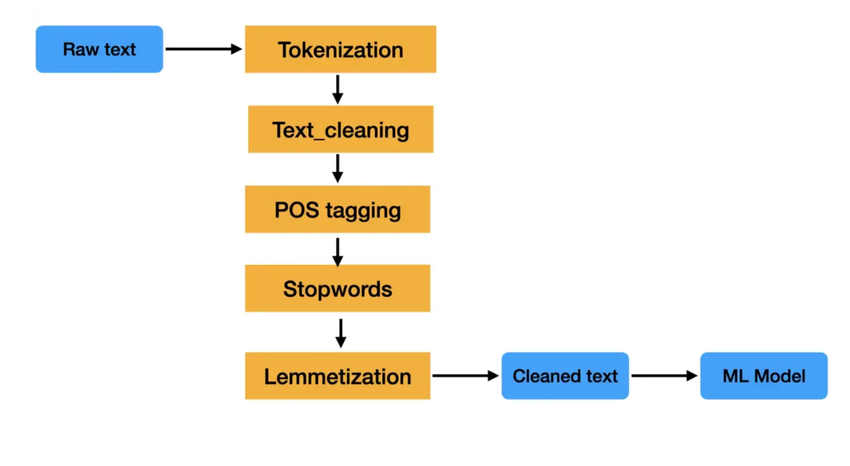

# **MODELO LINGUISTICO**

**El modelo linguístico se refiere a un modelo que predice o genera el siguiente componente asignando una probabilidad a los elementos del lenguaje (letra, palabra, morfema, cadena (frase), párrafo, etc.).**

- El modelo lingüístico se divide en modelo lingüístico estadístico (SLM) y modelo lingüístico de aprendizaje profundo basado en una red neuronal artificial.

- Esencialmente, los modelos lingüísticos, basados en una palabra dada, predicen la siguiente palabra o combinación de palabras, y dicha función puede resolver numerosos problemas de procesamiento del lenguaje natural, como la generación de documentos, la traducción automática,
el resumen de documentos, etc.

**Este se encarga de ...**

* Predice la probabilidad de una secuencia: P(w_1,w_2,w_3, ... ,w_i)
Precaucion: El subindice de w significa el orden de tiempo real que no se puede cambiar.

.

* Dada una secuencia de palabras {w_1,w_2,w_3, ... ,w_(i-1)}

**¿cual es la probabilidad de w_i?**

P([w_i|w]_1,w_2,w_3, ... ,w_(i-1))?

.

* La escasez de datos es un problema importante, porque la mayoria de las secuencias (largas) aparecen con
muy poca frecuencia.

* **Aplicaciones prácticas:** traducción automática, reconocimiento de voz, corrección ortográfica, autorrelleno, etc.

---

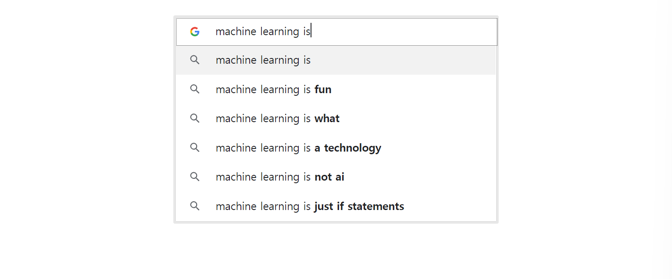

---

###**Probabilidad Conjunta**

La probabilidad conjunta es la probabilidad de que dos o más eventos ocurran al mismo tiempo.

Probabilidad de que aparezcan juntas dos palabras: “modelo” seguido de “matemático”.

P("modelo", "matematico")

En modelos de lenguaje, esto se calcula a partir de frecuencias en un corpus.



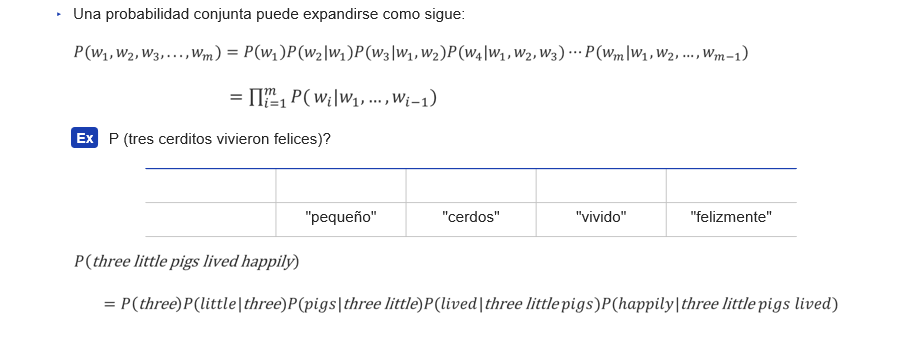

---

###**n-grams**

Un n-gram es una secuencia de n palabras (o caracteres) consecutivas en un texto.

**Tipos comunes:**

* 1-gram (unigram): 1 palabra

          “hola”

* 2-gram (bigram): 2 palabras

          “hola mundo”

* 3-gram (trigram): 3 palabras

          “cómo estás hoy”

* 4-gram, 5-gram… y así sucesivamente.

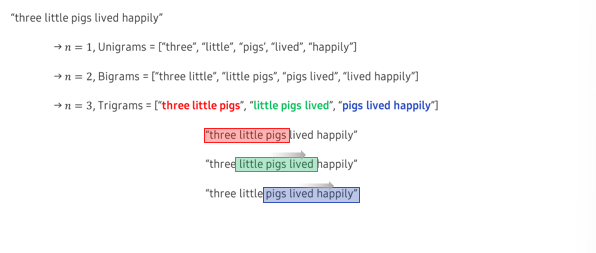

**Los n-grams se usan para aproximar probabilidades conjuntas.**

En lugar de calcular:

  𝑃
  (
  𝑤
  1
  ,
  𝑤
  2
  ,
  𝑤
  3
  ,
  .
  .
  .
  ,
  𝑤
  𝑛
  )

  .

**Se asume que la probabilidad de una palabra depende solo de las últimas n−1 palabras.**

---

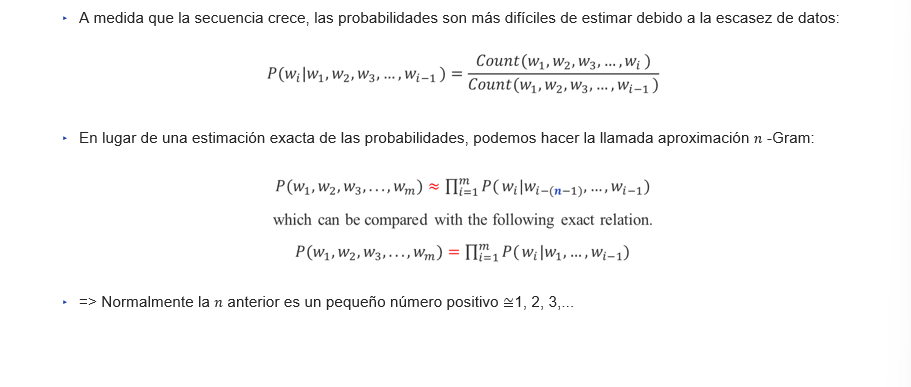

---

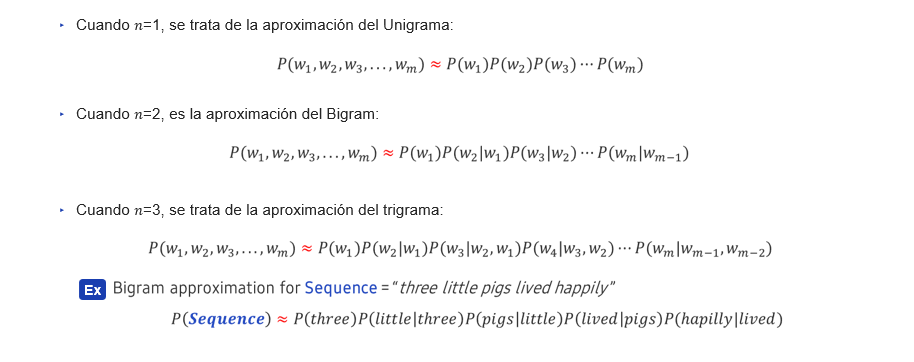

####**EJEMPLO**

**Tenemos este texto:**

> *"los gatos comen pescado. los perros comen carne."*

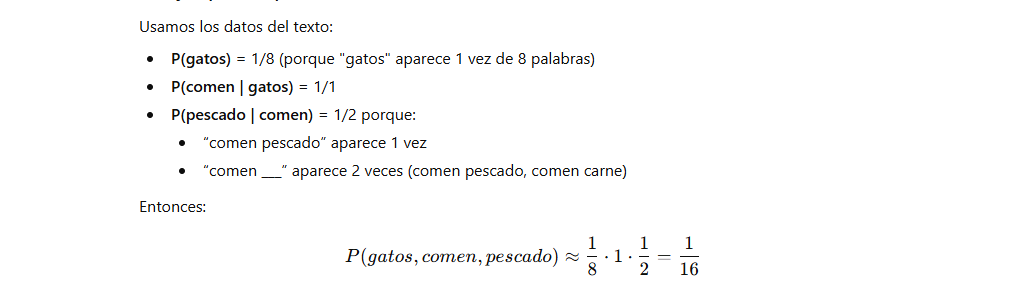

## **MODELO DE REPRESENTACION**

Un modelo de representación es la forma en que convertimos texto (palabras, frases o documentos) en números para que un algoritmo pueda procesarlos.

- Las computadoras no entienden palabras.
- Solo entienden números, vectores, matrices.

**Por eso, cuando trabajamos en Procesamiento del Lenguaje Natural (PLN), necesitamos transformar el lenguaje humano en alguna estructura numérica que capture:**

* qué palabras aparecen

* qué significado tienen

* qué relación existe entre ellas

**Un modelo de representación define precisamente cómo numerizamos el lenguaje.**

##**Tipos de modelos de representación**

**Existen tres grandes grupos:**

**A. Modelos basados en conteo**

Representan un documento contando palabras.

- Bag of Words (BoW)

- TF-IDF

**B. Modelos semánticos (vectores densos)**

Representan palabras según su significado y contexto estadístico.

- Word2Vec

- GloVe

- FastText

**C. Embeddings contextuales (los más modernos)***

La representación cambia según el contexto.

- BERT

- GPT

- RoBERTa

**Estos últimos son los más potentes hoy en día.**

###**Qué es Bag of Words (BoW)**

Bag of Words o "Bolsa de Palabras" es uno de los modelos de representación más simples.

**Su idea principal es:**

Representar un texto únicamente contando cuántas veces aparece cada palabra, sin importar el orden.

**Se llama así porque:**

- Se toman todas las palabras del documento.

- Se mezclan como si estuvieran dentro de una bolsa.

- Se cuentan las frecuencias.

- El orden de aparición se ignora completamente.

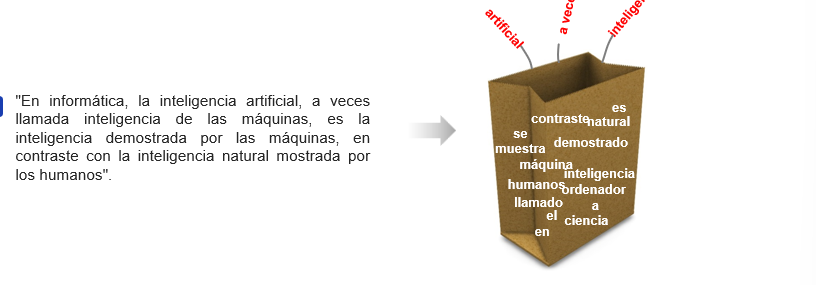

###**Características de BoW**

- No entiende contexto.

- No entiende significado.

- No detecta sarcasmo.

- No sabe si una palabra es adjetivo o verbo.

- Solo cuenta frecuencia de aparición de cada palabra.

**Es un método sencillo pero útil para:**

- clasificación de texto básica

- detección de spam

- análisis preliminar

- modelos tradicionales (no neuronales)

###**Ejemplo de Bag of Words**

**Supón estos dos textos:**

T1: "El perro ladra fuerte"
T2: "El gato duerme mucho"

**Primero creamos un vocabulario general con todas las palabras únicas:**

    ["el", "perro", "ladra", "fuerte", "gato", "duerme", "mucho"]

**Ahora representamos cada texto como un vector contando cuántas veces aparece cada palabra.**

    Vector T1:
    [1, 1, 1, 1, 0, 0, 0]

    Vector T2:
    [1, 0, 0, 0, 1, 1, 1]

**Eso es Bag of Words**

---

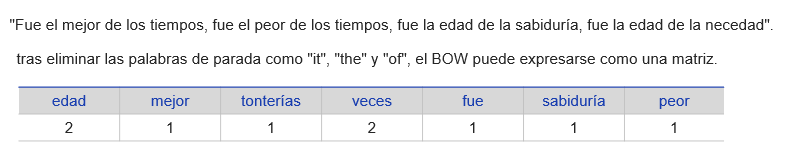

---

##**MATRIZ DOCUMENTO-TERMINO Y MATRIZ TERMINO-DOCUMENTO**

Una Matriz Documento–Término (DTM) y una Matriz Término–Documento (TDM) son esencialmente lo mismo, solo que organizadas de manera inversa. Ambas son representaciones fundamentales en procesamiento de lenguaje natural (NLP) y recuperación de información, usadas para modelar colecciones de textos.

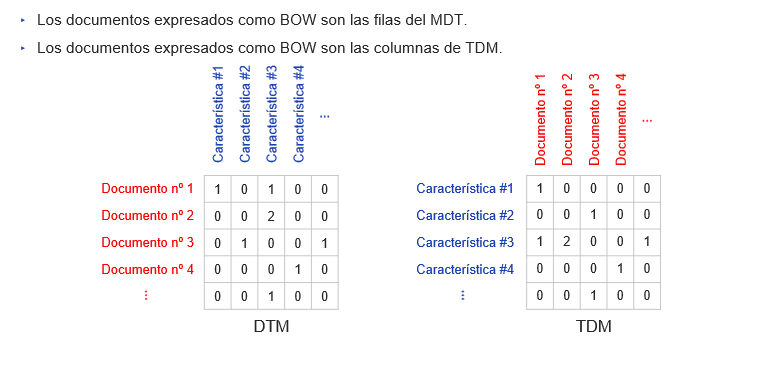

####**MATRIZ DOCUMENTO-TERMINO (DTM)**

Es una matriz donde cada fila es un documento y cada columna es un término (palabra).

Las celdas contienen típicamente la frecuencia con que el término aparece en el documento (o algún peso como TF-IDF).

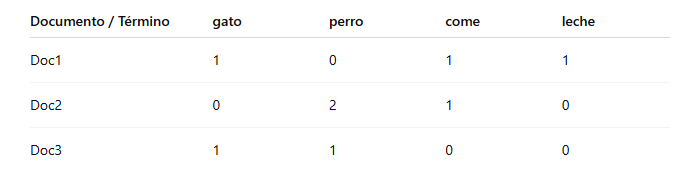

**Estructura:**

* Fila → documento

* Columna → palabra

* Celda → frecuencia (o peso)

####**MATRIZ TERMINO-DOCUMENTO (TDM)**

Es simplemente la versión transpuesta de la DTM:

* Filas = términos

* Columnas = documentos

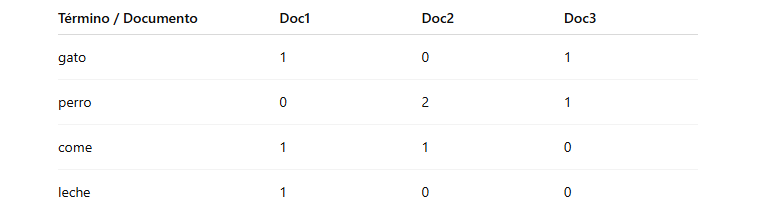

###**¿Por qué existen las dos?**

**Porque depende del objetivo:**

.

**Documento-Término (DTM)**

Más intuitiva.

**Se usa para:**

- Clasificación de documentos

- Análisis de sentimientos

- Agrupación (clustering) de textos

- Entrenamiento de modelos de PLN

**Término-Documento (TDM)**

- Se usa más en análisis estadístico de vocabulario.

- Útil cuando el análisis se hace por palabra:

- Frecuencias globales de términos

- Medidas de similitud entre palabras

- Modelado semántico (LSA, SVD)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

corpus = ["perro ladra", "gato maulla"]

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

# Documento-Término
dtm = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print("DTM:\n", dtm)

# Término-Documento (transpuesta)
tdm = dtm.T
print("\nTDM:\n", tdm)


DTM:
    gato  ladra  maulla  perro
0     0      1       0      1
1     1      0       1      0

TDM:
         0  1
gato    0  1
ladra   1  0
maulla  0  1
perro   1  0


---

###**Ventajas de BoW**

* Es muy fácil de implementar.

* No necesita grandes recursos.

* Es útil para modelos simples.

* Funciona bien cuando los textos no tienen estructuras complejas.

###**Desventajas de BoW**

- Ignora completamente el orden de las palabras.

- No entiende contexto.

- No entiende significado.

- Produce vectores muy grandes si el vocabulario es grande.

- No maneja variaciones del lenguaje (sinónimos, polisemia).

**Ejemplo:**

    "banco" como asiento o como institución será la misma palabra.



###**Para qué sirve en la práctica**

Aunque es simple, BoW se sigue usando en:

- Clasificadores de spam

- Sistemas básicos de recomendación de texto

- Análisis rápido de documentos

- Modelos de detección de temas preliminares

- Prototipos donde se necesita rapidez

- Es una forma fácil de comenzar antes de usar modelos más complejos como embeddings o Transformers.

---

###**FRECUENCIA DE TERMINOS**

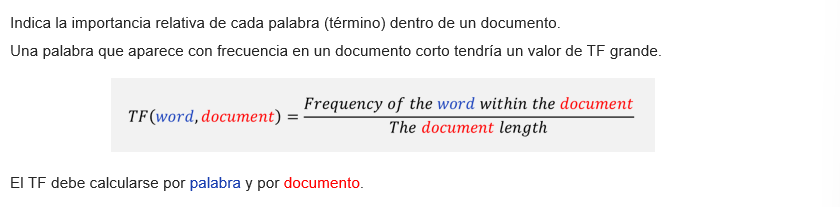

---
###**FRECUENCIA DE EQUIPO**

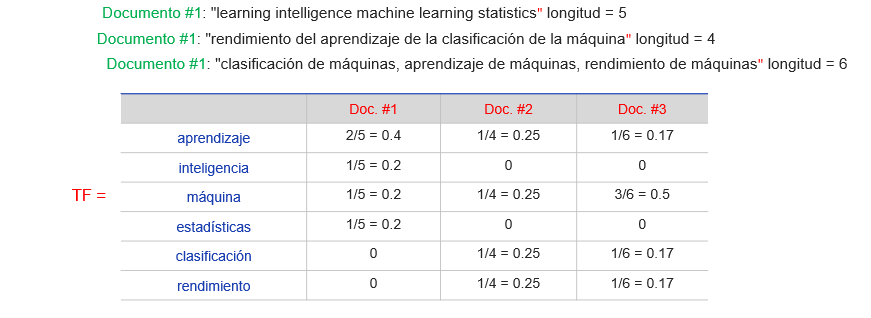

###**FRECUENCIA DE DOCUMENTOS Y FRECUENCIA INVERSA DE DOCUMENTOS**

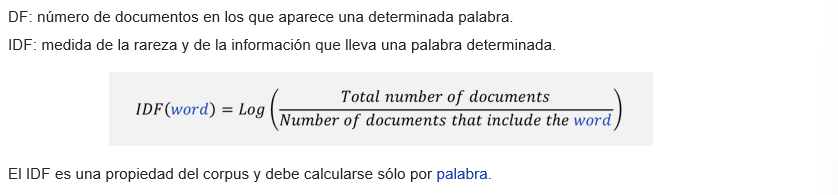

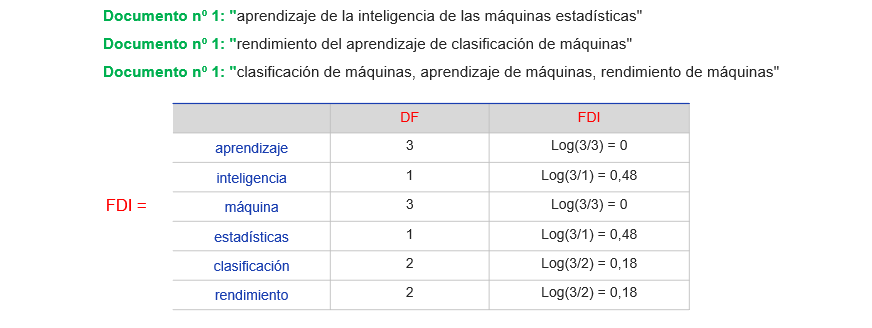

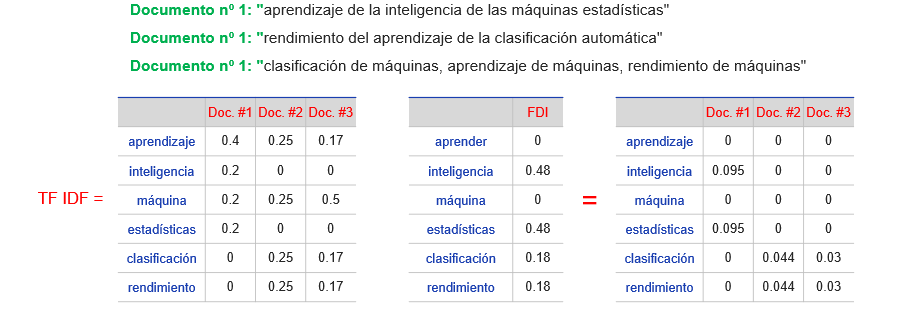